# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics

## How to use this notebook

### Local installation

1. Install required packages with `pip install -r requirements.txt` to your desired environment.
2. If a script version of this notebook is desired, comment (not uncomment) the first line of `nbconvert` cell.

### Colab installation

1.  Comment (not uncomment) the first line of the drive mounting cell.
2.  Comment (not uncomment) the first line of the `pip install` cell.

<!-- - For colab we also want to set the runtime to GPU by clicking _Change runtime_ in the _Runtime_ menu, and -->
<!-- - We want to wait for the google drive connection popup to appear and follow the instructions. -->

### Loading / Generating data
3. Set `LOAD_DATA_FROM_CSV` to `True` / `False` to load data from csv files / generate data in this notebook.

### Training without optimization

4. Set `OPTIMIZE = False` in section _Constants and flags to set_.
5. Run the entire notebook.

### Training with optimization

4. Set `OPTIMIZE = True` in section _Constants and flags to set_.
5. Run the entire notebook.

### Loading an already trained model

4. Run cells in section _Initialization_.
5. Run cells with definitions in section _Input data and labels_.
6. Run cell with the definition of _Net_ in section _Defining the neural network_.
7. Make sure the `net.pth`, `optimizer.pth`, `scheduler.pth`, `var_dict.json` and `train_output.csv` files are in the directory containing this notebook.
8. Run the cells in section _Loading_ and continue from there.

### Generating the C++ model

9. Run section _Porting the model to C++_, this requires a model to be loaded.
10. Set the path to the `net.pt` file in the C++ source file.
11. `mkdir build && cd build`,
12. Configure a `CMakeLists.txt` file as is done [here](https://pytorch.org/cppdocs/installing.html).
13. `cmake -DCMAKE_PREFIX_PATH=/path/to/libtorch/ ..`,
14. Compile and run, e.g. `cmake --build . --config release && ./<executable name>`

## Initialization


Use this first cell to **convert this notebook** to a python script.

In [4]:
%%script echo skipping

!jupyter nbconvert GRMHD_ML.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on **google colab**,

In [5]:
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")
# change this to your desired folder
drive_folder = "/content/drive/My Drive/bsc/con2prim_GRMHD/1e5_runs/adjusted_layers"

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [6]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#%%script echo skipping

!pip install optuna optuna[visualization] tensorboard tensorboardX plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 14.3 MB/s eta 0:00:00


Importing the **libraries**,

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx
import pandas as pd
import json
import pickle

### Constants and flags to set
Defining some constants and parameters for convenience.

**NOTE**: Some **subparameters** still need to be adjusted in the `create_model` function itself as of (Tue May 16 07:42:45 AM CEST 2023) in the case the model is being trained without optimization.

In [9]:

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_TRIALS = 5000 # Number of trials for hyperparameter optimization # NOTE: Set this properly.
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values. # NOTE: Set this properly.
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.
LOAD_DATA_FROM_CSV = False  # If not true we generate the data in this file and save to {x_train,y_train,x_test,y_test}.csv, otherwise we load the data from files of the same name. # NOTE: Set this before properly.
STUDY_NAME='1e5_run4_adjusted_layers'

csv_filenames = { # File names to load input data and labels from if LOAD_DATA_FROM_CSV is True.
    "x_train": "x_train.csv",
    "x_val": "x_val.csv",
    "x_test": "x_test.csv",
    "y_train": "y_train.csv",
    "y_val": "y_val.csv",
    "y_test": "y_test.csv",
}

# Values to use for hyperparameters if OPTIMIZE is False; set these to the best parameters found by Optuna.
# NOTE: TODO: Currently (Sat May 27 05:16:57 PM CEST 2023) there are still subparameters to be set in create_model function.
N_LAYERS_NO_OPT = 3
N_UNITS_NO_OPT = [555, 458, 115]
HIDDEN_ACTIVATION_NAME_NO_OPT = "LeakyReLU"
OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
LOSS_NAME_NO_OPT = "Huber"
OPTIMIZER_NAME_NO_OPT = "RMSprop"
LR_NO_OPT = 0.000122770896701404
BATCH_SIZE_NO_OPT = 49
N_EPOCHS_NO_OPT = 500 # NOTE: Set this properly.
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"
DROPOUT_RATE_NO_OPT = 0.2

N_INPUTS = 14  # Number of input features.
N_OUTPUTS = 1  # Number of outputs.
Gamma = 5/3  # Adiabatic index

n_samples = 1e5 # NOTE: Set this properly.
train_frac = 0.7  # 70% of data for training
val_frac = 0.15  # 15% of data for validation, rest for testing

rho_interval = (0, 2) 
epsilon_interval = (1e-2, 2000)  # Will be sampled in log space
vx_interval = (0, 0.999)  
vy_interval = (0, 0.999)  
vz_interval = (0, 0.999)  
Bx_interval = (-10, 10)  
By_interval = (-10, 10)  
Bz_interval = (-10, 10)  
gxx_interval = (0.9, 1.1)
gxy_interval = (0, 0.1)
gxz_interval = (0, 0.1)
gyy_interval = (0.9, 1.1)
gyz_interval = (0, 0.1)
gzz_interval = (0.9, 1.1)

np.random.seed(91) # Comment for true random data.


## Input data and labels

We either generate the data or load the data. First the definitions for generating the data come below.

In [10]:
# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    # Adding some assertions to check that the input tensors are valid and have 
    # the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    print('rho.shape: ', rho.shape)
    print('epsilon.shape: ', epsilon.shape)
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (Gamma - 1) * rho * epsilon

def sample_primitive_variables_and_metric():
    rho = np.random.uniform(*rho_interval)  
    epsilon = np.random.uniform(*np.log10(epsilon_interval))
    vx = np.random.uniform(*vx_interval)  
    vy = np.random.uniform(*vy_interval)  
    vz = np.random.uniform(*vz_interval)  
    Bx = np.random.uniform(*Bx_interval)  
    By = np.random.uniform(*By_interval)  
    Bz = np.random.uniform(*Bz_interval)  
    gxx = np.random.uniform(*gxx_interval)
    gxy = np.random.uniform(*gxy_interval)
    gxz = np.random.uniform(*gxz_interval)
    gyy = np.random.uniform(*gyy_interval)
    gyz = np.random.uniform(*gyz_interval)
    gzz = np.random.uniform(*gzz_interval)

    return rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz

def check_sample(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    wtemp_expr = 1 - (gxx * vx**2 + gyy * vy**2 + gzz * vz**2 + 2 * gxy * vx * vy + 2 * gxz * vx * vz + 2 * gyz * vy * vz)
    sdet_expr = gxx * gyy * gzz + 2 * gxy * gxz * gyz - gxx * gyz ** 2 - gyy * gxz ** 2 - gzz * gxy ** 2
    if vx**2 + vy**2 + vz**2 >= 1 or wtemp_expr < 0 or sdet_expr < 0:
        # print(f"Sample failed checks. vx^2+vy^2+vz^2: {vx**2 + vy**2 + vz**2}, wtemp_expr: {wtemp_expr}, sdet_expr: {sdet_expr}")
        return False
    else:
        # print(f"Sample passed checks. vx^2+vy^2+vz^2: {vx**2 + vy**2 + vz**2}, wtemp_expr: {wtemp_expr}, sdet_expr: {sdet_expr}")
        return True

def generate_samples(n_samples):
    samples = []
    while len(samples) < n_samples:
        sample = sample_primitive_variables_and_metric()
        if check_sample(*sample):
            samples.append(sample)
        # print(f"Number of valid samples: {len(samples)}")
    return zip(*samples)
def sdet(gxx, gxy, gxz, gyy, gyz, gzz):
    # Determinant of the three metric.
    return (gxx * gyy * gzz + 2 * gxy * gxz * gyz - gxx * gyz ** 2 - gyy * gxz ** 2 - gzz * gxy ** 2) ** 0.5

# Defining a function that computes conserved variables from primitive variables and the metric
# We follow the source code of GRaM-X: A new GPU-accelerated dynamical spacetime GRMHD code for Exascale
# computing with the Einstein Toolkit of Shankar et al.
def compute_conserved_variables(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    pres = eos_analytic(rho, epsilon)
    wtemp = 1 / (1 - (gxx * vx**2 + gyy * vy**2 + gzz * vz**2 +
        2 * gxy * vx * vy + 2 * gxz * vx * vz +
        2 * gyz * vy * vz))**0.5

    vlowx = gxx * vx + gxy * vy + gxz * vz
    vlowy = gxy * vx + gyy * vy + gyz * vz
    vlowz = gxz * vx + gyz * vy + gzz * vz

    Bxlow = gxx * Bx + gxy * By + gxz * Bz
    Bylow = gxy * Bx + gyy * By + gyz * Bz
    Bzlow = gxz * Bx + gyz * By + gzz * Bz

    B2 = Bxlow * Bx + Bylow * By + Bzlow * Bz

    Bdotv = Bxlow * vx + Bylow * vy + Bzlow * vz
    Bdotv2 = Bdotv * Bdotv
    wtemp2 = wtemp * wtemp
    b2 = B2 / wtemp2 + Bdotv2
    ab0 = wtemp * Bdotv

    blowx = (gxx * Bx + gxy * By + gxz * Bz) / wtemp + wtemp * Bdotv * vlowx
    blowy = (gxy * Bx + gyy * By + gyz * Bz) / wtemp + wtemp * Bdotv * vlowy
    blowz = (gxz * Bx + gyz * By + gzz * Bz) / wtemp + wtemp * Bdotv * vlowz

    hrhow2 = (rho * (1 + epsilon) + pres + b2) * (wtemp) * (wtemp)

    D = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * rho * (wtemp)
    Sx = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowx - ab0 * blowx)
    Sy = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowy - ab0 * blowy)
    Sz = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowz - ab0 * blowz)
    tau = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 - pres - b2 / 2 - ab0 * ab0) - D
    Bconsx = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * Bx
    Bconsy = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * By
    Bconsz = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * Bz

    return D, Sx, Sy, Sz, tau, Bconsx, Bconsy, Bconsz

def generate_input_data(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    rho = torch.tensor(np.array(rho), dtype=torch.float32).to(device)
    epsilon = torch.tensor(np.array(epsilon), dtype=torch.float32).to(device)
    vx = torch.tensor(np.array(vx), dtype=torch.float32).to(device)
    vy = torch.tensor(np.array(vy), dtype=torch.float32).to(device)
    vz = torch.tensor(np.array(vz), dtype=torch.float32).to(device)
    Bx = torch.tensor(np.array(Bx), dtype=torch.float32).to(device)
    By = torch.tensor(np.array(By), dtype=torch.float32).to(device)
    Bz = torch.tensor(np.array(Bz), dtype=torch.float32).to(device)
    gxx = torch.tensor(np.array(gxx), dtype=torch.float32).to(device)
    gxy = torch.tensor(np.array(gxy), dtype=torch.float32).to(device)
    gxz = torch.tensor(np.array(gxz), dtype=torch.float32).to(device)
    gyy = torch.tensor(np.array(gyy), dtype=torch.float32).to(device)
    gyz = torch.tensor(np.array(gyz), dtype=torch.float32).to(device)
    gzz = torch.tensor(np.array(gzz), dtype=torch.float32).to(device)

    D, Sx, Sy, Sz, tau, Bscriptx, Bscripty, Bscriptz = compute_conserved_variables(
        rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz
    ) 

    # Add gxx, gxy, gxz, gyy, gyz, gzz to the tensor
    x = torch.stack([D, Sx, Sy, Sz, tau, Bscriptx, Bscripty, Bscriptz, gxx, gxy, gxz, gyy, gyz, gzz], axis=1)
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
# We use the definitions as given in Recovery schemes for primitive variables in
# general-relativistic magnetohydrodynamics of Siegel et al.
def generate_labels(rho, epsilon, vx, vy, vz):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(np.array(rho), dtype=torch.float32).to(device)
    epsilon = torch.tensor(np.array(epsilon), dtype=torch.float32).to(device)
    vx = torch.tensor(np.array(vx), dtype=torch.float32).to(device)
    vy = torch.tensor(np.array(vy), dtype=torch.float32).to(device)
    vz = torch.tensor(np.array(vz), dtype=torch.float32).to(device)

    # Computing the required quantities
    pres = eos_analytic(rho, epsilon)
    h = 1 + epsilon + pres / rho
    W = 1 / torch.sqrt(1 - (vx * vx + vy * vy + vz * vz))

    # Returning the output data tensor
    return h * W

### Generating or loading input data and labels

In [11]:
%config InteractiveShell.ast_node_interactivity = "all"

In [12]:
if LOAD_DATA_FROM_CSV:
    # Load the data from CSV files
    x_train = pd.read_csv(csv_filenames["x_train"]).values
    y_train = pd.read_csv(csv_filenames["y_train"]).values.squeeze()  # reshape to 1D
    x_val = pd.read_csv(csv_filenames["x_val"]).values
    y_val = pd.read_csv(csv_filenames["y_val"]).values.squeeze()  # reshape to 1D
    x_test = pd.read_csv(csv_filenames["x_test"]).values
    y_test = pd.read_csv(csv_filenames["y_test"]).values.squeeze()  # reshape to 1D

    # Convert numpy arrays to tensors
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    x_val = torch.from_numpy(x_val).float().to(device)
    y_val = torch.from_numpy(y_val).float().to(device)
    x_test = torch.from_numpy(x_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

    # This is an alternative to having if clauses around the cells that visualize these variables.
    rho = epsilon = vx = vy = vz = Bx = By = Bz = gxx = gxy = gxz = gyy = gyz  = gzz = None

In [13]:
if not LOAD_DATA_FROM_CSV:
    # Sample primitive variables and metric
    rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz = generate_samples(n_samples)

In [14]:
if not LOAD_DATA_FROM_CSV:
    # Generate data and labels.
    x = generate_input_data(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz)
    y = generate_labels(rho, epsilon, vx, vy, vz)

    # Calculate the number of samples in each set
    n_train_samples = int(n_samples * train_frac)
    n_val_samples = int(n_samples * val_frac)

    # Create the data sets
    x_train = x[:n_train_samples]
    y_train = y[:n_train_samples]
    x_val = x[n_train_samples : n_train_samples + n_val_samples]
    y_val = y[n_train_samples : n_train_samples + n_val_samples]
    x_test = x[n_train_samples + n_val_samples :]
    y_test = y[n_train_samples + n_val_samples :]

    # Save the data to CSV files; tensors need to be converted numpy arrays for saving in CSV.
    pd.DataFrame(x_train.cpu().numpy()).to_csv(csv_filenames["x_train"], index=False)
    save_file(csv_filenames["x_train"])
    pd.DataFrame(y_train.cpu().numpy()).to_csv(csv_filenames["y_train"], index=False)
    save_file(csv_filenames["y_train"])

    pd.DataFrame(x_val.cpu().numpy()).to_csv(csv_filenames["x_val"], index=False)
    save_file(csv_filenames["x_val"])
    pd.DataFrame(y_val.cpu().numpy()).to_csv(csv_filenames["y_val"], index=False)
    save_file(csv_filenames["y_val"])

    pd.DataFrame(x_test.cpu().numpy()).to_csv(csv_filenames["x_test"], index=False)
    save_file(csv_filenames["x_test"])
    pd.DataFrame(y_test.cpu().numpy()).to_csv(csv_filenames["y_test"], index=False)
    save_file(csv_filenames["y_test"])

rho.shape:  torch.Size([100000])
epsilon.shape:  torch.Size([100000])
rho.shape:  torch.Size([100000])
epsilon.shape:  torch.Size([100000])


In [15]:

x_train.shape
y_train.shape
x_val.shape
y_val.shape
x_test.shape
y_test.shape
x_train
y_train
x_val
y_val
x_test
y_test

torch.Size([70000, 14])

torch.Size([70000])

torch.Size([15000, 14])

torch.Size([15000])

torch.Size([15000, 14])

torch.Size([15000])

tensor([[ 4.4684e-01,  1.5065e+00, -2.3501e+00,  ...,  9.1522e-01,
          3.4261e-02,  9.6139e-01],
        [ 1.7326e+00,  1.8291e+01, -2.5263e+00,  ...,  9.3787e-01,
          4.6801e-02,  1.0303e+00],
        [ 8.1560e-02, -1.3190e+00,  8.3835e-01,  ...,  9.2153e-01,
          4.8176e-02,  1.0497e+00],
        ...,
        [ 1.9611e+00, -8.7116e+00,  3.8659e+01,  ...,  9.8604e-01,
          8.9338e-02,  9.2787e-01],
        [ 1.5218e+00,  5.5179e+00,  4.4414e-01,  ...,  9.3965e-01,
          7.8723e-02,  1.0533e+00],
        [ 1.5397e+00,  9.7826e+00,  6.8052e+00,  ...,  9.3768e-01,
          1.1780e-02,  1.0672e+00]], device='cuda:0')

tensor([ 0.6442,  7.1512, -4.7510,  ...,  5.9678, -0.3853,  0.9425],
       device='cuda:0')

tensor([[ 3.7612e+00,  7.3917e+01,  2.3497e+01,  ...,  1.0621e+00,
          4.4504e-02,  1.0551e+00],
        [ 8.2474e-01,  2.4085e+01,  1.7873e+00,  ...,  9.7482e-01,
          4.0641e-03,  9.3812e-01],
        [ 7.6580e-01,  1.0988e+01,  3.7218e+01,  ...,  1.0084e+00,
          5.0477e-02,  1.0228e+00],
        ...,
        [ 2.4254e+00,  2.0606e+01,  1.3514e+01,  ...,  1.0895e+00,
          2.1703e-02,  9.0106e-01],
        [ 3.6347e+00,  1.6204e+01,  4.2041e+01,  ...,  1.0126e+00,
          6.8391e-02,  1.0750e+00],
        [ 7.0306e-01, -2.7878e+00, -3.9045e-01,  ...,  9.4128e-01,
          3.3790e-02,  1.0452e+00]], device='cuda:0')

tensor([10.0199,  3.6123,  6.4114,  ..., -0.5113,  7.7757,  5.2508],
       device='cuda:0')

tensor([[ 6.7747e-01,  4.7921e+01,  4.6454e+01,  ...,  9.0003e-01,
          3.7725e-02,  1.0061e+00],
        [ 3.6055e-01,  3.7422e+01,  3.1673e+01,  ...,  9.3217e-01,
          1.1468e-03,  1.0156e+00],
        [ 3.3188e+00,  1.2399e+01, -7.1275e+00,  ...,  1.0205e+00,
          2.3871e-02,  1.0499e+00],
        ...,
        [ 3.4012e+00,  5.0824e+01,  2.1991e+01,  ...,  1.0287e+00,
          9.7234e-02,  9.9444e-01],
        [ 2.2704e+00, -1.8069e+01,  3.8630e+01,  ...,  9.8837e-01,
          9.7089e-02,  9.1093e-01],
        [ 7.9651e-01,  1.2632e+01, -5.4843e+00,  ...,  1.0952e+00,
          3.4551e-02,  9.7640e-01]], device='cuda:0')

tensor([-5.7810,  7.7032, -1.9475,  ..., -2.3625,  7.4652,  1.4388],
       device='cuda:0')

In [16]:
torch.isnan(x_train).any()
torch.isnan(x_val).any()
torch.isnan(x_test).any()
torch.isnan(y_train).any()
torch.isnan(y_val).any()
torch.isnan(y_test).any()

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

In [17]:
nan_mask_train = torch.isnan(x_train)     # get a boolean mask indicating NaN values
nan_indices_train = torch.where(nan_mask_train)  # get the indices of the NaN values
nan_indices_train
# len(nan_indices_train)

nan_mask_val = torch.isnan(x_val)     # get a boolean mask indicating NaN values
nan_indices_val = torch.where(nan_mask_val)  # get the indices of the NaN values
nan_indices_val
# len(nan_indices_test)

nan_mask_test = torch.isnan(x_test)     # get a boolean mask indicating NaN values
nan_indices_test = torch.where(nan_mask_test)  # get the indices of the NaN values
nan_indices_test
# len(nan_indices_test)

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

## Visualizing the data

### Visualizing sampled data

In [18]:
%%script echo skipping

if not LOAD_DATA_FROM_CSV:
    rho
    epsilon
    vx
    vy
    vz 
    Bx
    By
    Bz
    gxx
    gxy
    gxz
    gyy
    gyz
    gzz 

skipping


In [19]:
if not LOAD_DATA_FROM_CSV:
    print(len(rho))
    print(len(epsilon))
    print(len(vx))
    print(len(vy))
    print(len(vz))
    print(len(Bx))
    print(len(By))
    print(len(Bz))
    print()
    print(len(gxx))
    print(len(gxy))
    print(len(gxz))
    print(len(gyy))
    print(len(gyz))
    print(len(gzz))

100000
100000
100000
100000
100000
100000
100000
100000

100000
100000
100000
100000
100000
100000


In [20]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [21]:
%%script echo skipping

plt.hist([np.random.uniform(0, 0.999) for _ in range(n_train_samples)], bins=20)

skipping


In [22]:
%%script echo skipping

epsilon

skipping


The reason the sampling is not uniformly distributed in the following plots is due to the resampling and the fact that we certain values of e.g. velocity are more likely to violate the speed of light constraint than others.

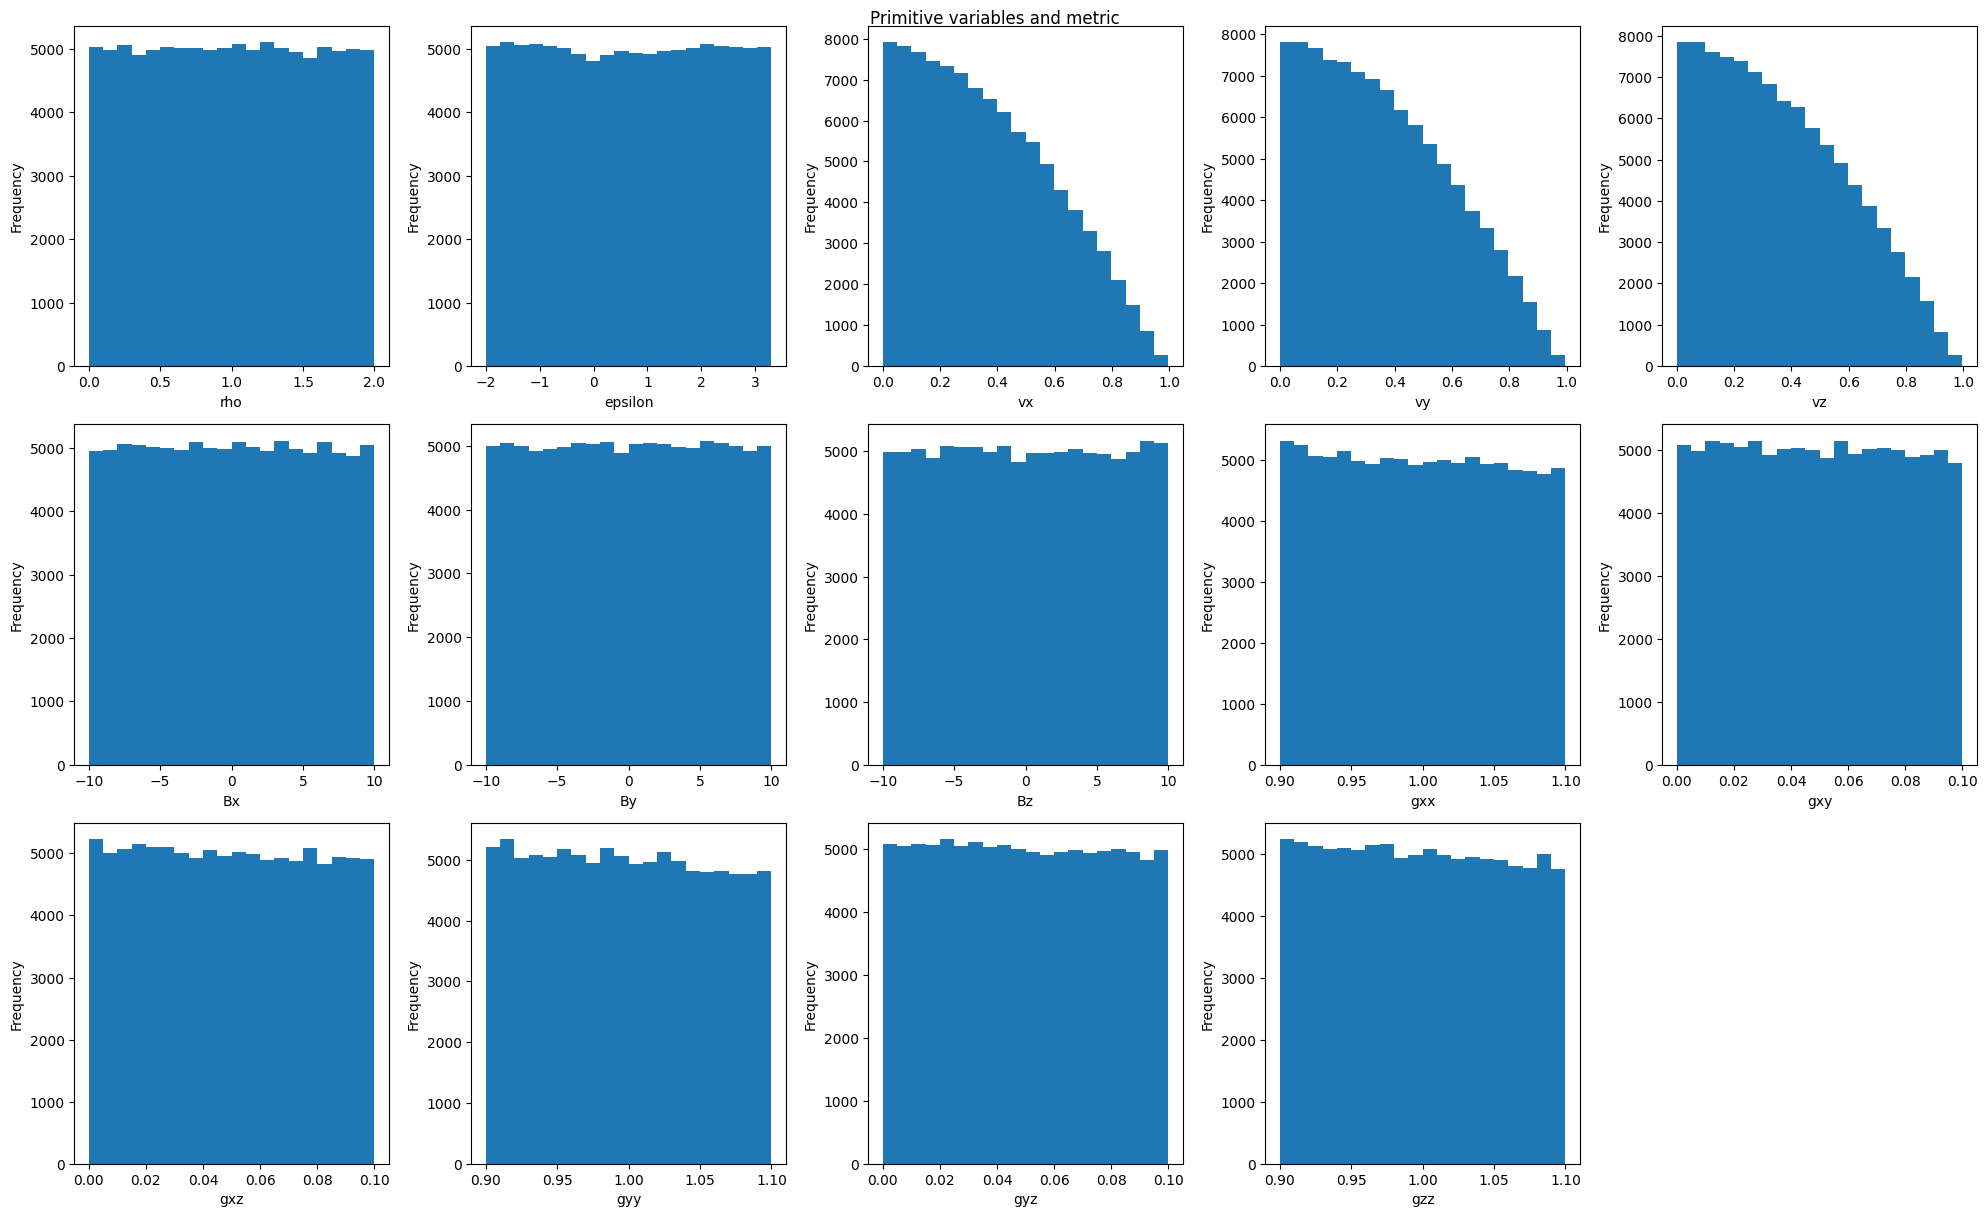

In [23]:
#%%script echo skipping

if not LOAD_DATA_FROM_CSV:
    def plot_histogram(data, xlabel, ylabel, position, bins=20, xlog_scale=False, ylog_scale=False):
        plt.subplot(4, 5, position)
        plt.hist(data, bins=bins)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if xlog_scale: # Setting does not work expected for epsilon.
            plt.xscale("log")
        if ylog_scale: # Setting does not work expected for epsilon.
            plt.yscale("log")

    # Plotting the histograms of rho, vx, epsilon, b0, b1, b2, and b3
    bins = 20
    plt.figure(figsize=(20, 16))

    plot_histogram(rho, "rho", "Frequency", 1, bins=bins)
    plot_histogram(epsilon, "epsilon", "Frequency", 2, bins=bins)
    plot_histogram(vx, "vx", "Frequency", 3, bins=bins)
    plot_histogram(vy, "vy", "Frequency", 4, bins=bins)
    plot_histogram(vz, "vz", "Frequency", 5, bins=bins)
    plot_histogram(Bx, "Bx", "Frequency", 6, bins=bins)
    plot_histogram(By, "By", "Frequency", 7, bins=bins)
    plot_histogram(Bz, "Bz", "Frequency", 8, bins=bins)

    # Plot these
    plot_histogram(gxx, "gxx", "Frequency", 9, bins=bins)
    plot_histogram(gxy, "gxy", "Frequency", 10, bins=bins)
    plot_histogram(gxz, "gxz", "Frequency", 11, bins=bins)
    plot_histogram(gyy, "gyy", "Frequency", 12, bins=bins)
    plot_histogram(gyz, "gyz", "Frequency", 13, bins=bins)
    plot_histogram(gzz, "gzz", "Frequency", 14, bins=bins)


    plt.suptitle("Primitive variables and metric")
    plt.tight_layout()
    plt.show()


In [24]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

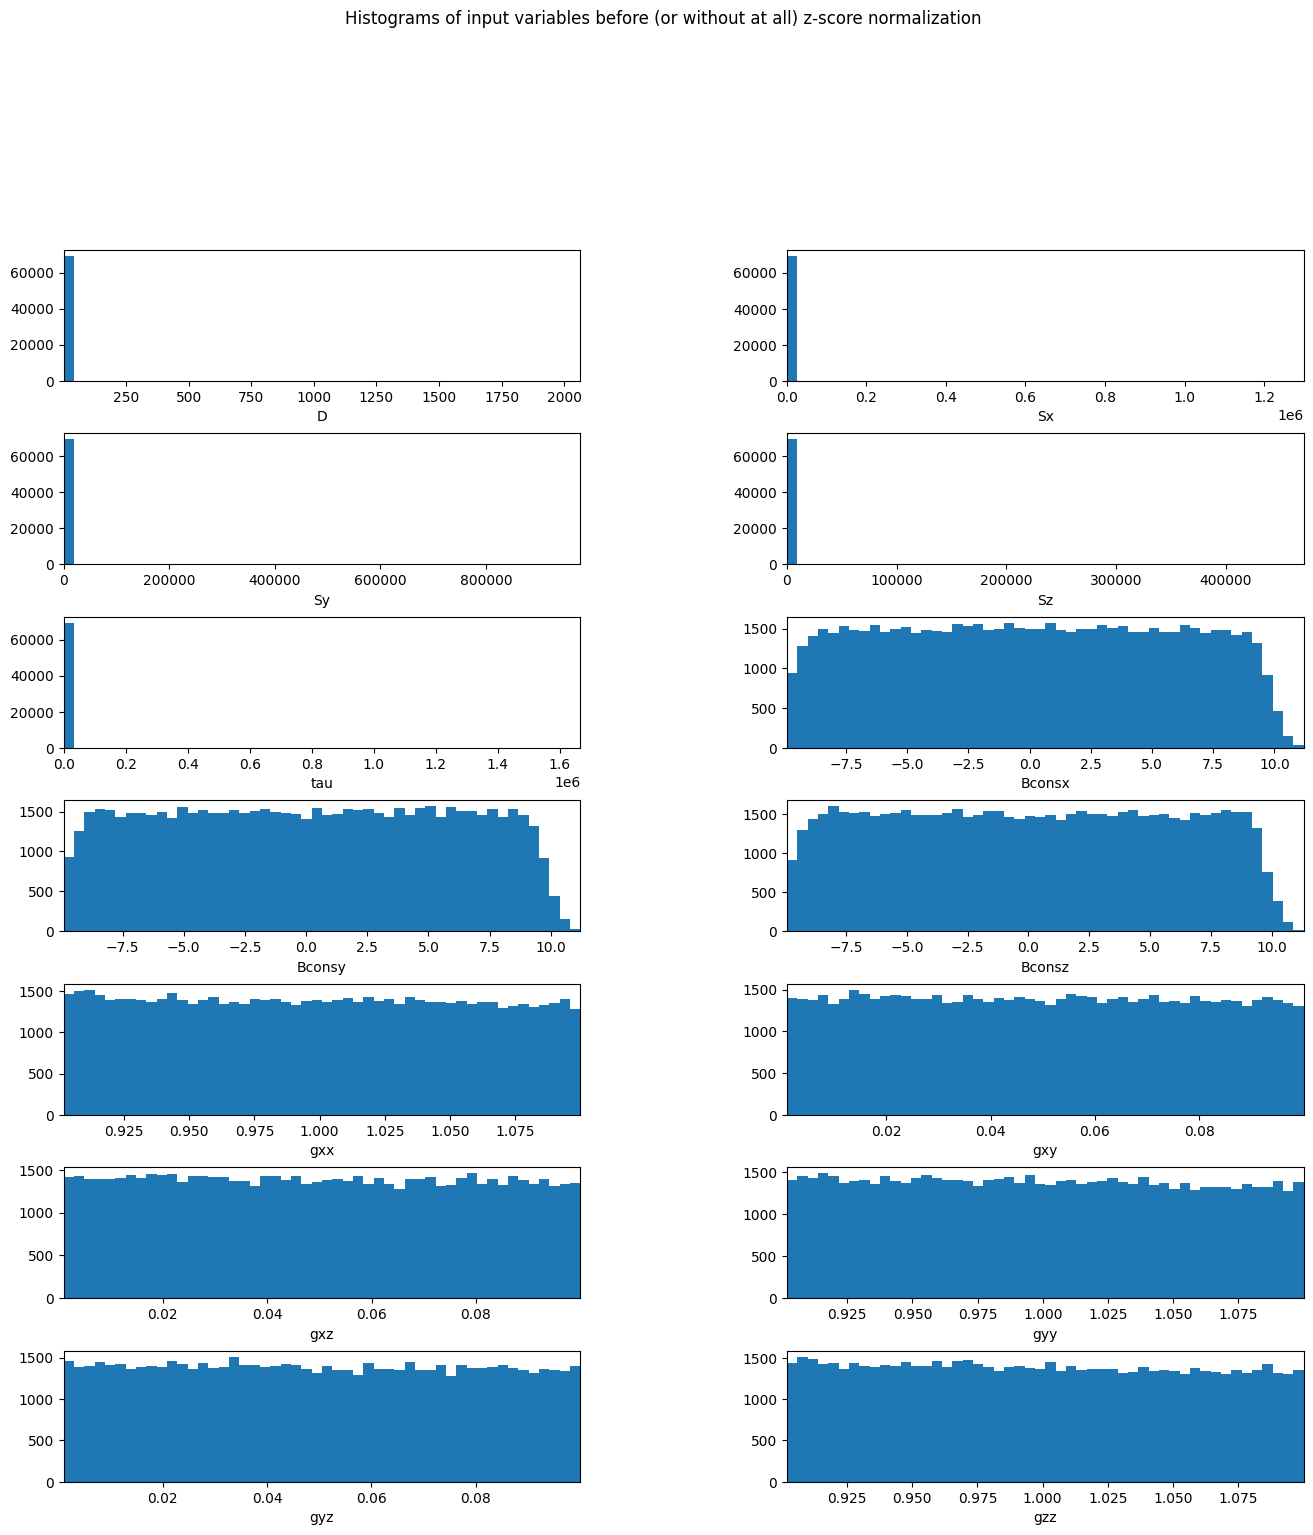

In [25]:
#%%script echo skipping

# Variable names
variable_names = ["D", "Sx", "Sy", "Sz", "tau", "Bconsx", "Bconsy", "Bconsz", "gxx", "gxy", "gxz", "gyy", "gyz", "gzz"]

# Plotting histograms of the input variables before z-score normalization
plt.figure(figsize=(16, 16))
plt.suptitle('Histograms of input variables before (or without at all) z-score normalization', y=1.03)

for i in range(N_INPUTS):
    plt.subplot(7, 2, i+1)
    data = x_train[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
    lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
    # lower_bound, upper_bound = np.percentile(data, [1, 90]) # Calculate 1st and 99th percentile

    plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
    plt.xlabel(variable_names[i])
    plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

# Same plotting but for the test data. Adjust the percentile range as needed to zoom in.
# plt.figure(figsize=(16, 16))
# plt.suptitle('Histograms of input variables before (or without at all) z-score normalization (test data)', y=1.03)

# for i in range(14):
#     plt.subplot(7, 2, i+1)
#     data = x_test[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
#     #lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
#     lower_bound, upper_bound = np.percentile(data, [1, 99]) # Use this to zoom in.

#     plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
#     plt.xlabel(variable_names[i])
#     plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

# plt.subplots_adjust(hspace=0.4, wspace=0.4)
# plt.show()



### Data normalization

In [26]:
# Computing summary statistics of the input variables before and after z-score normalization
print('Summary statistics of input variables before z-score normalization')
print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.nanmean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))

Summary statistics of input variables before z-score normalization
tensor([[ 2.3410e-05,  2.0643e+03,  2.3150e+00,  1.6678e+00,  8.7773e+00],
        [-1.8313e+04,  1.2995e+06,  6.0919e+01,  2.2053e+01,  4.9588e+03],
        [-7.7549e+04,  9.7829e+05,  5.3607e+01,  2.1977e+01,  3.7541e+03],
        [-3.0909e+04,  4.7100e+05,  5.0692e+01,  2.1806e+01,  2.0724e+03],
        [-7.9737e+04,  1.6657e+06,  1.2245e+02,  6.9601e+01,  6.4414e+03],
        [-1.1142e+01,  1.1190e+01, -1.0575e-02, -1.9842e-02,  5.7128e+00],
        [-1.1206e+01,  1.1203e+01,  1.2412e-02,  3.3881e-02,  5.7297e+00],
        [-1.1253e+01,  1.1306e+01, -2.6358e-06, -1.9080e-02,  5.7518e+00],
        [ 9.0000e-01,  1.1000e+00,  9.9869e-01,  9.9857e-01,  5.7853e-02],
        [ 3.5108e-07,  9.9999e-02,  4.9659e-02,  4.9512e-02,  2.8827e-02],
        [ 4.2349e-07,  1.0000e-01,  4.9567e-02,  4.9349e-02,  2.8875e-02],
        [ 9.0000e-01,  1.1000e+00,  9.9863e-01,  9.9790e-01,  5.7659e-02],
        [ 7.5907e-07,  9.9998e-02

Perform z-score normalization

In [27]:
%config InteractiveShell.ast_node_interactivity = "all"

In [28]:
if ZSCORE_NORMALIZATION:
    
    # TODO: Add magnetic field variables to the normalization if I decide to use the old code that is commented out here.
    # # Computing the median of each input variable from the training set using torch.nanmedian function
    # D_median = torch.nanmedian(x_train[:, 0])
    # Sx_median = torch.nanmedian(x_train[:, 1])
    # Sy_median = torch.nanmedian(x_train[:, 2])
    # Sz_median = torch.nanmedian(x_train[:, 3])
    # tau_median = torch.nanmedian(x_train[:, 4])

    # # Computing the standard deviation of each input variable from the training set using torch.std function with a boolean mask to ignore nan values
    # D_std = torch.std(x_train[~torch.isnan(x_train[:, 0]), 0])
    # Sx_std = torch.std(x_train[~torch.isnan(x_train[:, 1]), 1])
    # Sy_std = torch.std(x_train[~torch.isnan(x_train[:, 2]), 2])
    # Sz_std = torch.std(x_train[~torch.isnan(x_train[:, 3]), 3])
    # tau_std = torch.std(x_train[~torch.isnan(x_train[:, 4]), 4])


    # # Applying z-score normalization to both train and test sets using the statistics from the training set
    # x_train[:, 0] = torch.sub(x_train[:, 0], D_median).div(D_std)
    # x_train[:, 1] = torch.sub(x_train[:, 1], Sx_median).div(Sx_std)
    # x_train[:, 2] = torch.sub(x_train[:, 2], Sy_median).div(Sy_std)
    # x_train[:, 3] = torch.sub(x_train[:, 3], Sz_median).div(Sz_std)
    # x_train[:, 4] = torch.sub(x_train[:, 4], tau_median).div(tau_std)

    # x_test[:, 0] = torch.sub(x_test[:, 0], D_median).div(D_std)
    # x_test[:, 1] = torch.sub(x_test[:, 1], Sx_median).div(Sx_std)
    # x_test[:, 2] = torch.sub(x_test[:, 2], Sy_median).div(Sy_std)
    # x_test[:, 3] = torch.sub(x_test[:, 3], Sz_median).div(Sz_std)
    # x_test[:, 4] = torch.sub(x_test[:, 4], tau_median).div(tau_std)

    # Computing the mean and standard deviation of each column
    mean = x_train.mean(dim=0)
    std = x_train.std(dim=0)

    # Applying z-score normalization
    x_train = (x_train - mean) / std
    # Use the same mean and std from the training data as we don't want test data leakage.
    x_test = (x_test - mean) / std



Plotting the histograms of the input data after normalization if z-score normalization was performed.

In [29]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [30]:
if not LOAD_DATA_FROM_CSV:
    if ZSCORE_NORMALIZATION:
        # Variable names
        variable_names = ["D", "Sx", "Sy", "Sz", "tau", "Bconsx", "Bconsy", "Bconsz", "gxx", "gxy", "gxz", "gyy", "gyz", "gzz"]

        # Plotting histograms of the input variables before z-score normalization
        plt.figure(figsize=(16, 16))
        plt.suptitle('Histograms of input variables before (or without at all) z-score normalization', y=1.03)

        for i in range(N_INPUTS):
            plt.subplot(7, 2, i+1)
            data = x_train[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
            lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
            # lower_bound, upper_bound = np.percentile(data, [1, 90]) # Calculate 1st and 99th percentile

            plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
            plt.xlabel(variable_names[i])
            plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()

In [31]:
if ZSCORE_NORMALIZATION:
    # Computing summary statistics of the input variables after z-score normalization
    print('Summary statistics of input variables after z-score normalization')
    print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.mean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))


### Visualizing input data and labels

In [32]:
x_train
y_train
x_val
y_val
x_test
y_test

tensor([-5.7810,  7.7032, -1.9475,  ..., -2.3625,  7.4652,  1.4388],
       device='cuda:0')

Checking if our output is always positive ~~by plotting a histogram of y_train and y_test tensors~~

In [33]:
import torch

# Create a sample tensor
tensor = torch.randn(80000, 14)  # Assuming a tensor of shape [80000, 14]
tensor


# Check if any element is negative
any_negative = torch.any(tensor < 0)

# Print the result
print(any_negative)


tensor(True)


In [34]:
y_train.shape
any_negative = torch.any(y_train < 0)
any_negative

y_test.shape
any_negative = torch.any(y_test < 0)
any_negative

x_train.shape
any_negative = torch.any(x_train < 0)
any_negative

tensor(True, device='cuda:0')

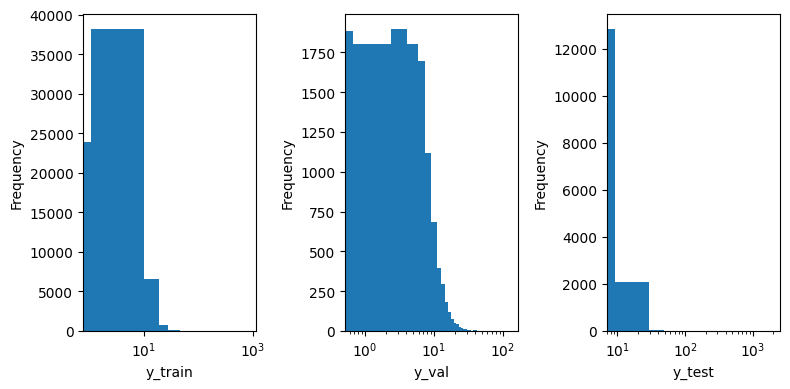

In [35]:
#%%script echo skipping

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.hist(y_train.cpu().numpy(), bins=100) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.xscale("log")
plt.subplot(1, 3, 2)
plt.hist(y_val.cpu().numpy(), bins=100) # must be cpu here
plt.xlabel("y_val")
plt.ylabel("Frequency")
plt.xscale("log")
plt.tight_layout()
plt.subplot(1, 3, 3)
plt.hist(y_test.cpu().numpy(), bins=100) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.xscale("log")
plt.tight_layout()
plt.show()


In [36]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [37]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation, dropout_rate):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
            TODO: [ver. Copilot description] dropout_rate (float): The dropout rate to use for all layers.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.dropout_rate = dropout_rate

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        self.layers.append(nn.Linear(N_INPUTS, n_units[0]))
        self.dropouts.append(nn.Dropout(p=dropout_rate))

        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
            self.dropouts.append(nn.Dropout(p=dropout_rate))

        self.layers.append(nn.Linear(n_units[-1], N_OUTPUTS))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, N_INPUTS).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, N_OUTPUTS).
        """
        # Adding an assertion to check that the input tensor has the expected shape and type
        assert isinstance(x, torch.Tensor), "x must be a torch.Tensor"
        assert x.shape[1] == N_INPUTS, f"x must have shape (batch_size, {N_INPUTS})"

        for layer, dropout in zip(self.layers[:-1], self.dropouts):
            x = dropout(self.hidden_activation(layer(x)))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x)) # No dropout at output layer

        return x # Returning the output tensor


In [38]:
%%script echo skipping

[1,2,3]
[1,2,3][:-1]

skipping


In [39]:
for x in [1,2,3][:-1]:
    print(x)



1
2


## Defining the model and search space

In [40]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
            dropout_rate is the dropout rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if OPTIMIZE:
        n_layers = trial.suggest_int("n_layers", 2, 6)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 4096) for i in range(n_layers)]

        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "PReLU", "Swish", "GELU", "SoftPlus"]
        )
        output_activation_name = trial.suggest_categorical( "output_activation", ["Linear"])

        loss_name = trial.suggest_categorical( "loss", ["MSE", "MAE", "Huber", "Quantile"]) 

        optimizer_name = trial.suggest_categorical( "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] )

        lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)

        batch_size_list = [32, 64, 128, 256, 512, 1024, 2048]
        batch_size = trial.suggest_categorical("batch_size", batch_size_list)
        
        n_epochs = trial.suggest_int("n_epochs", 50, 150)

        # scheduler_name = trial.suggest_categorical("scheduler", ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "CyclicLR"])
        scheduler_name = trial.suggest_categorical("scheduler", ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR"])

        # Creating the activation functions from their names
        if hidden_activation_name == "ReLU":
            hidden_activation = nn.ReLU()
        elif hidden_activation_name == "LeakyReLU":
            negative_slope = trial.suggest_uniform("leakyrelu_slope", 0.01, 0.3)
            hidden_activation = nn.LeakyReLU(negative_slope=negative_slope)
        elif hidden_activation_name == "ELU":
            hidden_activation = nn.ELU() 
        elif hidden_activation_name == "PReLU":
            init = trial.suggest_uniform("prelu_init", 0.1, 0.3)
            hidden_activation = nn.PReLU(init=init)
        elif hidden_activation_name == "Swish":
            class Swish(nn.Module):
                def forward(self, x):
                    return x * torch.sigmoid(x)
            hidden_activation = Swish()
        elif hidden_activation_name == "GELU":
            hidden_activation = nn.GELU()
        elif hidden_activation_name == "SoftPlus":
            beta = trial.suggest_uniform("softplus_beta", 0.5, 1.5)
            hidden_activation = nn.Softplus(beta=beta) # We don't optimize thresshold subparameters, as it's mainly for numerical stability.

        dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)


    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT

        # Creating the activation functions from their names
        if hidden_activation_name == "ReLU":
            hidden_activation = nn.ReLU()
        elif hidden_activation_name == "LeakyReLU":
            negative_slope = 0.01
            hidden_activation = nn.LeakyReLU(negative_slope=negative_slope)
        elif hidden_activation_name == "ELU":
            hidden_activation = nn.ELU() 
        elif hidden_activation_name == "PReLU":
            init = 0.25
            hidden_activation = nn.PReLU(init=init)
        elif hidden_activation_name == "Swish":
            class Swish(nn.Module):
                def forward(self, x):
                    return x * torch.sigmoid(x)
            hidden_activation = Swish()
        elif hidden_activation_name == "GELU":
            hidden_activation = nn.GELU()
        elif hidden_activation_name == "SoftPlus":
            beta = 1
            hidden_activation = nn.Softplus(beta=beta) # We don't optimize threshold subparameter, as it's mainly for numerical stability.

        dropout_rate = DROPOUT_RATE_NO_OPT


    # We used to have options here, but since we have a regression problem with continuous output, we only use Linear.
    output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    elif loss_name == "Quantile":
        def quantile_loss(y_pred, y_true, q=0.5):
            e = y_pred - y_true
            return torch.mean(torch.max(q*e, (q-1)*e))
        loss_fn = quantile_loss
    else:
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(n_layers, n_units, hidden_activation, output_activation, dropout_rate).to(device)


    if OPTIMIZE:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
            beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.1, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            if n_epochs < 150:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
            elif n_epochs > 250:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.05, 0.1)
            else:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.2)

            T_max = int(n_epochs * t_max_fraction)
            eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
        elif scheduler_name == "ReduceLROnPlateau":
            factor = trial.suggest_uniform("factor", 0.1, 0.5)
            patience = trial.suggest_int("patience", 5, 10)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        elif scheduler_name == "CyclicLR":
            base_lr = trial.suggest_loguniform("base_lr", 1e-6, 1e-2)
            max_lr = trial.suggest_loguniform("max_lr", 1e-4, 1)
            step_size_up = trial.suggest_int("step_size_up", 200, 2000)
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up)
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer)
        elif scheduler_name == "ReduceLROnPlateau":
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.18979341786654758, patience=11, threshold=0.0017197466122611932 #, min_lr=1e-6
                    )
        elif scheduler_name == "CyclicLR":
            # TODO: Change these appropriately.
            base_lr = 1e-6
            max_lr = 1e-4
            step_size_up = 200
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up)
        else:
            scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr, dropout_rate




 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [41]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [42]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_loader, val_loader, test_loader, trial=None):
    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    val_losses = []
    test_losses = []
    train_metrics = []
    val_metrics = []
    test_metrics = []


    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        if val_loader is not None:
            net.eval()
            val_loss = 0.0
            val_l1_norm = 0.0
            val_linf_norm = 0.0

            with torch.no_grad():
                for x_batch, y_batch in val_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = net(x_batch)
                    loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)

                    val_loss += loss.item() * x_batch.size(0)
                    val_l1_norm += l1_norm.item() * x_batch.size(0)
                    val_linf_norm += linf_norm.item() * x_batch.size(0)

            val_loss /= len(val_loader.dataset)
            val_l1_norm /= len(val_loader.dataset)
            val_linf_norm /= len(val_loader.dataset)

            val_losses.append(val_loss)
            val_metrics.append(
                {
                    "l1_norm": val_l1_norm,
                    "linf_norm": val_linf_norm,
                }
            )

            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("L1 norm/val", val_l1_norm, epoch)
            writer.add_scalar("Linf norm/val", val_linf_norm, epoch)
            print(f"Epoch {epoch+1}/{n_epochs}.. Train loss: {train_loss:.3f}.. Val loss: {val_loss:.3f}.. Train L1 norm: {train_l1_norm:.3f}.. Val L1 norm: {val_l1_norm:.3f}.. Train Linf norm: {train_linf_norm:.3f}.. Val Linf norm: {val_linf_norm:.3f}")


            update_scheduler(scheduler, val_loss)

        if test_loader is not None:
            net.eval()
            test_loss = 0.0
            test_l1_norm = 0.0
            test_linf_norm = 0.0

            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = net(x_batch)
                    loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)

                    test_loss += loss.item() * x_batch.size(0)
                    test_l1_norm += l1_norm.item() * x_batch.size(0)
                    test_linf_norm += linf_norm.item() * x_batch.size(0)

            test_loss /= len(test_loader.dataset)
            test_l1_norm /= len(test_loader.dataset)
            test_linf_norm /= len(test_loader.dataset)

            test_losses.append(test_loss)
            test_metrics.append(
                {
                    "l1_norm": test_l1_norm,
                    "linf_norm": test_linf_norm,
                }
            )

            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
            writer.add_scalar("Linf norm/test", test_linf_norm, epoch)
            print(f"Epoch {epoch+1}/{n_epochs}.. Train loss: {train_loss:.3f}.. Test loss: {test_loss:.3f}.. Train L1 norm: {train_l1_norm:.3f}.. Test L1 norm: {test_l1_norm:.3f}.. Train Linf norm: {train_linf_norm:.3f}.. Test Linf norm: {test_linf_norm:.3f}")


        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(val_l1_norm, epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics


## The objective function and hyperparameter tuning

In [43]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial, optimize=True)

    # Create separate data loaders for training and validation
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_val, y_val), batch_size=batch_size
    )
    
    _, _, _, _, val_metrics, _ = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_loader, val_loader, None, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return val_metrics[-1]["l1_norm"]

In [ ]:
# Visualize Optuna study while its running, alternative to tensorboard
#from IPython import display
import optuna.visualization as ov

def callback(study, trial):
    with open('all_trials.json', 'a') as f:
        # Save the trial number, value, and parameters to a JSON file.
        json.dump({
            'number': trial.number,
            'value': trial.value,
            'params': trial.params
        }, f)
        # Write a newline character after each trial, so that each trial is on a separate line
        f.write('\n')
        save_file('all_trials.json')

    # Saving the study to a pickle file
    with open(f'{STUDY_NAME}.pkl', 'wb') as f:
        pickle.dump(study, f)
        save_file(f'{STUDY_NAME}.pkl')

    # Save the best trial separately as well.
    best_trial_params = study.best_trial.params
    with open('best_trial_params.json', 'w') as f:
        json.dump(best_trial_params, f)
        save_file('best_trial_params.json')

    # Visualize the optimization history, and save it as an HTML file.
    fig1 = ov.plot_optimization_history(study)
    fig1.write_html(f"optimization_history_{STUDY_NAME}.html")
    save_file(f"optimization_history_{STUDY_NAME}.html")
    fig1.show()

    # Do the same for the other visualizations.
    fig2 = ov.plot_slice(study)
    fig2.write_html(f"slice_plot_{STUDY_NAME}.html")
    save_file(f"slice_plot_{STUDY_NAME}.html")

    # if trial.number % 10 == 0:
    #     fig3 = ov.plot_contour(study)
    #     fig3.write_html(f"contour_plot_{STUDY_NAME}.html")
    #     save_file(f"contour_plot_{STUDY_NAME}.html")

    fig4 = ov.plot_parallel_coordinate(study)
    fig4.write_html(f"parallel_coordinate_plot_{STUDY_NAME}.html")
    save_file(f"parallel_coordinate_plot_{STUDY_NAME}.html")

    if trial.number > 1: # Required
      fig5 = ov.plot_param_importances(study)
      fig5.write_html(f"param_importances_plot_{STUDY_NAME}.html")
      save_file(f"param_importances_plot_{STUDY_NAME}.html")

        
if OPTIMIZE:
    # Gave an error in my run on arch bsc_physics_env. It doesn't matter anyway, since we use pickle for saving.
    # Include the path to the SQLite file in your create_study call.
    # study = optuna.create_study(direction="minimize", 
                                # sampler=optuna.samplers.TPESampler(), 
                                # pruner=optuna.pruners.MedianPruner(), 
                                # storage=f'sqlite:///{STUDY_NAME}.db')
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    study.optimize(objective, n_trials=N_TRIALS, callbacks=[callback])
    #study.optimize(objective, n_trials=N_TRIALS)

[I 2023-06-01 10:04:22,278] A new study created in memory with name: no-name-a11a02dc-04dd-4f34-8ed1-7ee39d23bbcd
<ipython-input-40-46c28bc3cd67>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
<ipython-input-40-46c28bc3cd67>:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
<ipython-input-40-46c28bc3cd67>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
<ipython-input

Epoch 1/119.. Train loss: 46.296.. Val loss: 4.338.. Train L1 norm: 47.595.. Val L1 norm: 2.168.. Train Linf norm: 7102.972.. Val Linf norm: 301.532
Epoch 2/119.. Train loss: 4.444.. Val loss: 4.458.. Train L1 norm: 3.938.. Val L1 norm: 2.200.. Train Linf norm: 951.057.. Val Linf norm: 302.610
Epoch 3/119.. Train loss: 4.780.. Val loss: 4.170.. Train L1 norm: 4.686.. Val L1 norm: 3.438.. Train Linf norm: 1305.384.. Val Linf norm: 635.538
Epoch 4/119.. Train loss: 4.529.. Val loss: 4.201.. Train L1 norm: 4.317.. Val L1 norm: 2.208.. Train Linf norm: 1205.588.. Val Linf norm: 302.076
Epoch 5/119.. Train loss: 4.735.. Val loss: 4.139.. Train L1 norm: 3.725.. Val L1 norm: 1.987.. Train Linf norm: 911.727.. Val Linf norm: 250.190
Epoch 6/119.. Train loss: 5.244.. Val loss: 6.946.. Train L1 norm: 4.341.. Val L1 norm: 11.409.. Train Linf norm: 1171.818.. Val Linf norm: 2409.909
Epoch 7/119.. Train loss: 4.411.. Val loss: 4.324.. Train L1 norm: 5.205.. Val L1 norm: 2.582.. Train Linf norm: 150

[I 2023-06-01 10:09:35,831] Trial 0 finished with value: 2.517501590283712 and parameters: {'n_layers': 3, 'n_units_0': 3324, 'n_units_1': 4060, 'n_units_2': 374, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0005765064586969432, 'batch_size': 512, 'n_epochs': 119, 'scheduler': 'CosineAnnealingLR', 'dropout_rate': 0.21803158674096274, 't_max_fraction': 0.2879375684901083, 'eta_min': 0.0034815879822760894}. Best is trial 0 with value: 2.517501590283712.


Epoch 119/119.. Train loss: 1.908.. Val loss: 1.924.. Train L1 norm: 3.065.. Val L1 norm: 2.518.. Train Linf norm: 739.762.. Val Linf norm: 472.491


<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:168: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:175: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/65.. Train loss: 258.004.. Val loss: 3.713.. Train L1 norm: 157.040.. Val L1 norm: 4.543.. Train Linf norm: 22357.773.. Val Linf norm: 1254.234
Epoch 2/65.. Train loss: 3.992.. Val loss: 3.674.. Train L1 norm: 5.236.. Val L1 norm: 5.325.. Train Linf norm: 2129.507.. Val Linf norm: 1633.635
Epoch 3/65.. Train loss: 4.032.. Val loss: 3.507.. Train L1 norm: 5.468.. Val L1 norm: 4.706.. Train Linf norm: 2382.812.. Val Linf norm: 1438.826
Epoch 4/65.. Train loss: 3.702.. Val loss: 3.690.. Train L1 norm: 5.413.. Val L1 norm: 3.301.. Train Linf norm: 2238.758.. Val Linf norm: 1033.931
Epoch 5/65.. Train loss: 3.683.. Val loss: 3.448.. Train L1 norm: 5.193.. Val L1 norm: 3.707.. Train Linf norm: 1951.677.. Val Linf norm: 1096.970
Epoch 6/65.. Train loss: 3.830.. Val loss: 3.468.. Train L1 norm: 5.283.. Val L1 norm: 4.813.. Train Linf norm: 2046.359.. Val Linf norm: 1469.168
Epoch 7/65.. Train loss: 3.529.. Val loss: 3.418.. Train L1 norm: 5.181.. Val L1 norm: 4.149.. Train Linf norm: 1

[I 2023-06-01 10:13:41,360] Trial 1 finished with value: 7.353070700581869 and parameters: {'n_layers': 5, 'n_units_0': 3036, 'n_units_1': 1335, 'n_units_2': 3111, 'n_units_3': 1939, 'n_units_4': 3756, 'hidden_activation': 'Swish', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0003065714996976257, 'batch_size': 1024, 'n_epochs': 65, 'scheduler': 'CosineAnnealingLR', 'dropout_rate': 0.4221829975461546, 't_max_fraction': 0.24637332838007056, 'eta_min': 1.0249892140588182e-07}. Best is trial 0 with value: 2.517501590283712.


Epoch 65/65.. Train loss: 2.767.. Val loss: 3.234.. Train L1 norm: 4.253.. Val L1 norm: 7.353.. Train Linf norm: 1773.504.. Val Linf norm: 2216.502


<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/146.. Train loss: 1230345.612.. Val loss: 66460.905.. Train L1 norm: 677412.515.. Val L1 norm: 17060.986.. Train Linf norm: 170480241.732.. Val Linf norm: 17613780.885
Epoch 2/146.. Train loss: 39579.703.. Val loss: 2973.342.. Train L1 norm: 17742.461.. Val L1 norm: 2142.184.. Train Linf norm: 10554328.723.. Val Linf norm: 1499552.221
Epoch 3/146.. Train loss: 15343.716.. Val loss: 4245.304.. Train L1 norm: 5415.517.. Val L1 norm: 1669.294.. Train Linf norm: 4869797.126.. Val Linf norm: 1431051.784
Epoch 4/146.. Train loss: 4610.497.. Val loss: 35957.857.. Train L1 norm: 2633.727.. Val L1 norm: 12298.382.. Train Linf norm: 2383173.959.. Val Linf norm: 14983587.985
Epoch 5/146.. Train loss: 15186.947.. Val loss: 15588.175.. Train L1 norm: 4400.107.. Val L1 norm: 4717.834.. Train Linf norm: 2770729.425.. Val Linf norm: 4978854.422
Epoch 6/146.. Train loss: 13462.407.. Val loss: 9006.158.. Train L1 norm: 5361.421.. Val L1 norm: 1767.770.. Train Linf norm: 3993988.200.. Val Linf no

[I 2023-06-01 10:17:22,335] Trial 2 finished with value: 5.460429000854492 and parameters: {'n_layers': 2, 'n_units_0': 3019, 'n_units_1': 1991, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.04530163966418617, 'batch_size': 2048, 'n_epochs': 146, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.00525808549383372, 'factor': 0.10316025328698336, 'patience': 8, 'threshold': 0.00030245015462151677}. Best is trial 0 with value: 2.517501590283712.


Epoch 146/146.. Train loss: 3.610.. Val loss: 4.708.. Train L1 norm: 7.070.. Val L1 norm: 5.460.. Train Linf norm: 6594.238.. Val Linf norm: 2696.922


[W 2023-06-01 10:17:22,621] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:168: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:175: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/93.. Train loss: 5.287.. Val loss: 4.090.. Train L1 norm: 4.472.. Val L1 norm: 5.077.. Train Linf norm: 98.199.. Val Linf norm: 109.791
Epoch 2/93.. Train loss: 4.405.. Val loss: 4.049.. Train L1 norm: 4.265.. Val L1 norm: 4.958.. Train Linf norm: 90.129.. Val Linf norm: 107.464
Epoch 3/93.. Train loss: 4.660.. Val loss: 3.956.. Train L1 norm: 4.751.. Val L1 norm: 4.597.. Train Linf norm: 103.953.. Val Linf norm: 99.399
Epoch 4/93.. Train loss: 4.623.. Val loss: 4.124.. Train L1 norm: 5.060.. Val L1 norm: 3.858.. Train Linf norm: 111.721.. Val Linf norm: 81.086
Epoch 5/93.. Train loss: 4.497.. Val loss: 4.212.. Train L1 norm: 4.825.. Val L1 norm: 4.233.. Train Linf norm: 104.348.. Val Linf norm: 89.715
Epoch 6/93.. Train loss: 5.227.. Val loss: 4.413.. Train L1 norm: 5.166.. Val L1 norm: 5.320.. Train Linf norm: 115.211.. Val Linf norm: 114.875
Epoch 7/93.. Train loss: 4.959.. Val loss: 4.234.. Train L1 norm: 5.204.. Val L1 norm: 5.713.. Train Linf norm: 116.886.. Val Linf norm

[I 2023-06-01 10:28:01,390] Trial 3 finished with value: 4.791042903137207 and parameters: {'n_layers': 3, 'n_units_0': 2132, 'n_units_1': 635, 'n_units_2': 853, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0003599639109697564, 'batch_size': 32, 'n_epochs': 93, 'scheduler': 'CosineAnnealingLR', 'dropout_rate': 0.05520081464777826, 't_max_fraction': 0.15961689462691023, 'eta_min': 0.000750572644808631}. Best is trial 0 with value: 2.517501590283712.


Epoch 93/93.. Train loss: 5.680.. Val loss: 3.699.. Train L1 norm: 6.969.. Val L1 norm: 4.791.. Train Linf norm: 164.168.. Val Linf norm: 103.414


[W 2023-06-01 10:28:01,686] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/137.. Train loss: 146425.994.. Val loss: 189.100.. Train L1 norm: 9.111.. Val L1 norm: 1.500.. Train Linf norm: 220.782.. Val Linf norm: 14.360
Epoch 2/137.. Train loss: 34777.955.. Val loss: 159.349.. Train L1 norm: 7.386.. Val L1 norm: 1.433.. Train Linf norm: 158.731.. Val Linf norm: 13.894
Epoch 3/137.. Train loss: 54374.162.. Val loss: 228730.314.. Train L1 norm: 7.523.. Val L1 norm: 37.486.. Train Linf norm: 174.656.. Val Linf norm: 802.740
Epoch 4/137.. Train loss: 44937.891.. Val loss: 2877.709.. Train L1 norm: 7.513.. Val L1 norm: 3.738.. Train Linf norm: 154.837.. Val Linf norm: 66.703
Epoch 5/137.. Train loss: 157416.097.. Val loss: 707.280.. Train L1 norm: 20.366.. Val L1 norm: 3.881.. Train Linf norm: 505.572.. Val Linf norm: 77.943
Epoch 6/137.. Train loss: 956563.717.. Val loss: 3345.976.. Train L1 norm: 10.871.. Val L1 norm: 4.803.. Train Linf norm: 240.388.. Val Linf norm: 89.931
Epoch 7/137.. Train loss: 369876.474.. Val loss: 8290.472.. Train L1 norm: 11.519.

[I 2023-06-01 10:50:45,501] Trial 4 finished with value: 1.4571304793039959 and parameters: {'n_layers': 5, 'n_units_0': 3129, 'n_units_1': 833, 'n_units_2': 274, 'n_units_3': 1819, 'n_units_4': 104, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0018228416397986055, 'batch_size': 32, 'n_epochs': 137, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.18963045580059865, 'dropout_rate': 0.27407158843407664, 'factor': 0.17905277652819584, 'patience': 8, 'threshold': 0.00010329887802908851}. Best is trial 4 with value: 1.4571304793039959.


Epoch 137/137.. Train loss: 7528.399.. Val loss: 64.316.. Train L1 norm: 2.304.. Val L1 norm: 1.457.. Train Linf norm: 38.840.. Val Linf norm: 15.511


[W 2023-06-01 10:50:45,860] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:149: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Epoch 1/126.. Train loss: 5.687.. Val loss: 4.867.. Train L1 norm: 4.712.. Val L1 norm: 4.985.. Train Linf norm: 101.083.. Val Linf norm: 106.257


[W 2023-06-01 10:50:59,218] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:145: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Epoch 1/146.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[W 2023-06-01 10:51:14,994] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/136.. Train loss: 324319644.073.. Val loss: 10.373.. Train L1 norm: 180007423.245.. Val L1 norm: 22.201.. Train Linf norm: 7095629535.171.. Val Linf norm: 1517.708


[W 2023-06-01 10:51:25,876] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/52.. Train loss: 1445.440.. Val loss: 1632.662.. Train L1 norm: 1.912.. Val L1 norm: 2.956.. Train Linf norm: 148.638.. Val Linf norm: 282.520
Epoch 2/52.. Train loss: 22883.087.. Val loss: 123.359.. Train L1 norm: 4.013.. Val L1 norm: 1.763.. Train Linf norm: 500.127.. Val Linf norm: 123.222
Epoch 3/52.. Train loss: 13179.369.. Val loss: 2006.329.. Train L1 norm: 5.468.. Val L1 norm: 3.605.. Train Linf norm: 689.235.. Val Linf norm: 367.127
Epoch 4/52.. Train loss: 29548.422.. Val loss: 3396.328.. Train L1 norm: 3.774.. Val L1 norm: 5.397.. Train Linf norm: 509.099.. Val Linf norm: 670.808
Epoch 5/52.. Train loss: 65266.684.. Val loss: 1604.418.. Train L1 norm: 5.233.. Val L1 norm: 3.217.. Train Linf norm: 631.587.. Val Linf norm: 320.552
Epoch 6/52.. Train loss: 22149.517.. Val loss: 115.364.. Train L1 norm: 2.885.. Val L1 norm: 1.851.. Train Linf norm: 327.198.. Val Linf norm: 148.918
Epoch 7/52.. Train loss: 1008.852.. Val loss: 72.586.. Train L1 norm: 1.407.. Val L1 norm: 

[I 2023-06-01 10:52:58,705] Trial 8 finished with value: 1.48207164478302 and parameters: {'n_layers': 4, 'n_units_0': 673, 'n_units_1': 2600, 'n_units_2': 266, 'n_units_3': 3472, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.00037829381941961753, 'batch_size': 256, 'n_epochs': 52, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.21902718457725145, 'dropout_rate': 0.08979558445750357, 'factor': 0.1495761795135936, 'patience': 5, 'threshold': 0.0016672822819360036}. Best is trial 4 with value: 1.4571304793039959.


Epoch 52/52.. Train loss: 1564.099.. Val loss: 56.352.. Train L1 norm: 1.590.. Val L1 norm: 1.482.. Train Linf norm: 112.471.. Val Linf norm: 88.378


[W 2023-06-01 10:52:59,041] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:168: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/60.. Train loss: 6.609.. Val loss: 5.673.. Train L1 norm: 5.525.. Val L1 norm: 5.751.. Train Linf norm: 417.855.. Val Linf norm: 414.578


[W 2023-06-01 10:53:02,394] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:73: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:149: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Epoch 1/105.. Train loss: 73.024.. Val loss: 36.352.. Train L1 norm: 6.167.. Val L1 norm: 5.857.. Train Linf norm: 242.691.. Val Linf norm: 223.120


[W 2023-06-01 10:53:07,323] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/82.. Train loss: 387.961.. Val loss: 53.501.. Train L1 norm: 1.559.. Val L1 norm: 1.117.. Train Linf norm: 116.569.. Val Linf norm: 26.334
Epoch 2/82.. Train loss: 822.453.. Val loss: 55.507.. Train L1 norm: 1.359.. Val L1 norm: 1.095.. Train Linf norm: 78.888.. Val Linf norm: 21.230
Epoch 3/82.. Train loss: 1160.955.. Val loss: 65.798.. Train L1 norm: 1.316.. Val L1 norm: 1.128.. Train Linf norm: 68.980.. Val Linf norm: 25.859
Epoch 4/82.. Train loss: 234.729.. Val loss: 60.290.. Train L1 norm: 1.256.. Val L1 norm: 1.103.. Train Linf norm: 50.907.. Val Linf norm: 21.509
Epoch 5/82.. Train loss: 1239.111.. Val loss: 77.025.. Train L1 norm: 1.330.. Val L1 norm: 1.187.. Train Linf norm: 70.683.. Val Linf norm: 35.959
Epoch 6/82.. Train loss: 117.255.. Val loss: 73.715.. Train L1 norm: 1.246.. Val L1 norm: 1.168.. Train Linf norm: 47.263.. Val Linf norm: 32.701
Epoch 7/82.. Train loss: 180.572.. Val loss: 66.055.. Train L1 norm: 1.203.. Val L1 norm: 1.128.. Train Linf norm: 36.257

[I 2023-06-01 10:56:15,612] Trial 11 finished with value: 1.1455119774500528 and parameters: {'n_layers': 5, 'n_units_0': 71, 'n_units_1': 1257, 'n_units_2': 66, 'n_units_3': 3989, 'n_units_4': 1599, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 1.0928357139995508e-05, 'batch_size': 256, 'n_epochs': 82, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.21865750067153916, 'dropout_rate': 0.20563864590219588, 'factor': 0.20978444421034664, 'patience': 10, 'threshold': 0.00010978729872396592}. Best is trial 11 with value: 1.1455119774500528.


Epoch 82/82.. Train loss: 112.498.. Val loss: 71.008.. Train L1 norm: 1.189.. Val L1 norm: 1.146.. Train Linf norm: 33.771.. Val Linf norm: 28.736


[W 2023-06-01 10:56:15,932] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/85.. Train loss: 852.159.. Val loss: 88.644.. Train L1 norm: 1.373.. Val L1 norm: 1.303.. Train Linf norm: 70.111.. Val Linf norm: 64.479
Epoch 2/85.. Train loss: 2114.851.. Val loss: 75.242.. Train L1 norm: 1.428.. Val L1 norm: 1.238.. Train Linf norm: 90.210.. Val Linf norm: 52.596
Epoch 3/85.. Train loss: 5861.261.. Val loss: 64.910.. Train L1 norm: 1.374.. Val L1 norm: 1.175.. Train Linf norm: 80.780.. Val Linf norm: 40.420
Epoch 4/85.. Train loss: 514.808.. Val loss: 60.110.. Train L1 norm: 1.265.. Val L1 norm: 1.139.. Train Linf norm: 53.342.. Val Linf norm: 33.304
Epoch 5/85.. Train loss: 254.902.. Val loss: 62.029.. Train L1 norm: 1.292.. Val L1 norm: 1.158.. Train Linf norm: 60.294.. Val Linf norm: 37.024
Epoch 6/85.. Train loss: 490.478.. Val loss: 65.580.. Train L1 norm: 1.329.. Val L1 norm: 1.188.. Train Linf norm: 69.075.. Val Linf norm: 42.892
Epoch 7/85.. Train loss: 1117.020.. Val loss: 60.561.. Train L1 norm: 1.298.. Val L1 norm: 1.149.. Train Linf norm: 60.480

[I 2023-06-01 10:59:11,418] Trial 12 finished with value: 1.1281484175364176 and parameters: {'n_layers': 5, 'n_units_0': 185, 'n_units_1': 1219, 'n_units_2': 994, 'n_units_3': 1520, 'n_units_4': 1550, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 1.1190315627299871e-05, 'batch_size': 256, 'n_epochs': 85, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.23163002572240562, 'dropout_rate': 0.2499269868985033, 'factor': 0.3261728107102665, 'patience': 10, 'threshold': 0.00010082254263209124}. Best is trial 12 with value: 1.1281484175364176.


Epoch 85/85.. Train loss: 961.868.. Val loss: 56.632.. Train L1 norm: 1.326.. Val L1 norm: 1.128.. Train Linf norm: 69.746.. Val Linf norm: 31.124


[W 2023-06-01 10:59:11,761] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/86.. Train loss: 9832.560.. Val loss: 61.929.. Train L1 norm: 2.153.. Val L1 norm: 1.426.. Train Linf norm: 206.975.. Val Linf norm: 88.114
Epoch 2/86.. Train loss: 616.749.. Val loss: 82.143.. Train L1 norm: 1.572.. Val L1 norm: 1.228.. Train Linf norm: 104.439.. Val Linf norm: 46.841
Epoch 3/86.. Train loss: 2028.431.. Val loss: 97.616.. Train L1 norm: 1.680.. Val L1 norm: 1.214.. Train Linf norm: 145.587.. Val Linf norm: 39.970
Epoch 4/86.. Train loss: 1684.397.. Val loss: 134.605.. Train L1 norm: 1.689.. Val L1 norm: 1.244.. Train Linf norm: 140.347.. Val Linf norm: 38.493
Epoch 5/86.. Train loss: 247.395.. Val loss: 146.388.. Train L1 norm: 1.359.. Val L1 norm: 1.260.. Train Linf norm: 66.758.. Val Linf norm: 40.324
Epoch 6/86.. Train loss: 687.039.. Val loss: 114.149.. Train L1 norm: 1.491.. Val L1 norm: 1.230.. Train Linf norm: 98.458.. Val Linf norm: 38.796
Epoch 7/86.. Train loss: 945.785.. Val loss: 137.828.. Train L1 norm: 1.452.. Val L1 norm: 1.256.. Train Linf norm

[I 2023-06-01 11:02:46,935] Trial 13 finished with value: 1.2572816292444864 and parameters: {'n_layers': 4, 'n_units_0': 36, 'n_units_1': 1442, 'n_units_2': 4090, 'n_units_3': 780, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 1.3473605858221075e-05, 'batch_size': 256, 'n_epochs': 86, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.19273332873010682, 'factor': 0.34401715161031154, 'patience': 10, 'threshold': 0.00010314454947828252}. Best is trial 12 with value: 1.1281484175364176.


Epoch 86/86.. Train loss: 2278.066.. Val loss: 132.709.. Train L1 norm: 1.436.. Val L1 norm: 1.257.. Train Linf norm: 80.369.. Val Linf norm: 40.407


[W 2023-06-01 11:02:47,270] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:145: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Epoch 1/78.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[W 2023-06-01 11:02:51,537] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/106.. Train loss: 1154.922.. Val loss: 53.620.. Train L1 norm: 2.128.. Val L1 norm: 1.013.. Train Linf norm: 201.341.. Val Linf norm: 3.707
Epoch 2/106.. Train loss: 2690.427.. Val loss: 66.998.. Train L1 norm: 1.243.. Val L1 norm: 1.145.. Train Linf norm: 55.521.. Val Linf norm: 26.915
Epoch 3/106.. Train loss: 211.776.. Val loss: 58.562.. Train L1 norm: 1.192.. Val L1 norm: 1.055.. Train Linf norm: 39.827.. Val Linf norm: 11.523
Epoch 4/106.. Train loss: 79.763.. Val loss: 65.017.. Train L1 norm: 1.289.. Val L1 norm: 1.109.. Train Linf norm: 64.858.. Val Linf norm: 21.032
Epoch 5/106.. Train loss: 156.455.. Val loss: 78.379.. Train L1 norm: 1.139.. Val L1 norm: 1.196.. Train Linf norm: 29.353.. Val Linf norm: 35.343
Epoch 6/106.. Train loss: 228.953.. Val loss: 63.779.. Train L1 norm: 1.216.. Val L1 norm: 1.088.. Train Linf norm: 47.910.. Val Linf norm: 17.352
Epoch 7/106.. Train loss: 185.060.. Val loss: 56.097.. Train L1 norm: 1.267.. Val L1 norm: 1.028.. Train Linf norm: 6

[I 2023-06-01 11:08:28,900] Trial 15 finished with value: 1.1360727453867594 and parameters: {'n_layers': 6, 'n_units_0': 810, 'n_units_1': 691, 'n_units_2': 721, 'n_units_3': 1422, 'n_units_4': 1847, 'n_units_5': 4048, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 4.93613288869286e-05, 'batch_size': 256, 'n_epochs': 106, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.10889652807202574, 'dropout_rate': 0.2850808864645484, 'factor': 0.2816492517148155, 'patience': 10, 'threshold': 0.005990777945656252}. Best is trial 12 with value: 1.1281484175364176.


Epoch 106/106.. Train loss: 150.783.. Val loss: 77.771.. Train L1 norm: 1.195.. Val L1 norm: 1.136.. Train Linf norm: 42.931.. Val Linf norm: 25.172


[W 2023-06-01 11:08:29,286] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/104.. Train loss: 2.397.. Val loss: 2.114.. Train L1 norm: 4.431.. Val L1 norm: 4.460.. Train Linf norm: 581.950.. Val Linf norm: 553.717


[W 2023-06-01 11:08:34,277] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



Epoch 1/113.. Train loss: 4351.723.. Val loss: 52.192.. Train L1 norm: 1.635.. Val L1 norm: 1.093.. Train Linf norm: 777.921.. Val Linf norm: 87.894
Epoch 2/113.. Train loss: 394.570.. Val loss: 54.708.. Train L1 norm: 1.340.. Val L1 norm: 1.016.. Train Linf norm: 458.127.. Val Linf norm: 19.095
Epoch 3/113.. Train loss: 802.852.. Val loss: 59.893.. Train L1 norm: 1.233.. Val L1 norm: 1.049.. Train Linf norm: 323.920.. Val Linf norm: 43.287
Epoch 4/113.. Train loss: 70.937.. Val loss: 59.324.. Train L1 norm: 1.208.. Val L1 norm: 1.041.. Train Linf norm: 271.012.. Val Linf norm: 37.638
Epoch 5/113.. Train loss: 714.162.. Val loss: 63.498.. Train L1 norm: 1.207.. Val L1 norm: 1.074.. Train Linf norm: 276.897.. Val Linf norm: 61.511
Epoch 6/113.. Train loss: 173.968.. Val loss: 69.928.. Train L1 norm: 1.198.. Val L1 norm: 1.120.. Train Linf norm: 255.615.. Val Linf norm: 92.454
Epoch 7/113.. Train loss: 290.737.. Val loss: 73.276.. Train L1 norm: 1.136.. Val L1 norm: 1.141.. Train Linf no

[I 2023-06-01 11:12:09,543] Trial 17 finished with value: 1.11823533522288 and parameters: {'n_layers': 6, 'n_units_0': 739, 'n_units_1': 819, 'n_units_2': 873, 'n_units_3': 1173, 'n_units_4': 1173, 'n_units_5': 3840, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 5.7442872237377035e-05, 'batch_size': 2048, 'n_epochs': 113, 'scheduler': 'StepLR', 'dropout_rate': 0.3134429648325783, 'step_size': 12, 'gamma': 0.4652664870340759}. Best is trial 17 with value: 1.11823533522288.


Epoch 113/113.. Train loss: 769.614.. Val loss: 73.630.. Train L1 norm: 1.217.. Val L1 norm: 1.118.. Train Linf norm: 304.093.. Val Linf norm: 90.210


[W 2023-06-01 11:12:09,908] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:149: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:150: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Epoch 1/116.. Train loss: 679.404.. Val loss: 58.515.. Train L1 norm: 1.951.. Val L1 norm: 1.028.. Train Linf norm: 771.566.. Val Linf norm: 24.951
Epoch 2/116.. Train loss: 1787.221.. Val loss: 59.378.. Train L1 norm: 1.480.. Val L1 norm: 1.042.. Train Linf norm: 605.672.. Val Linf norm: 36.323
Epoch 3/116.. Train loss: 7782.579.. Val loss: 52.623.. Train L1 norm: 1.479.. Val L1 norm: 1.094.. Train Linf norm: 567.168.. Val Linf norm: 86.665
Epoch 4/116.. Train loss: 1519.804.. Val loss: 54.055.. Train L1 norm: 1.711.. Val L1 norm: 1.086.. Train Linf norm: 832.537.. Val Linf norm: 81.011
Epoch 5/116.. Train loss: 8926.692.. Val loss: 65.774.. Train L1 norm: 1.573.. Val L1 norm: 1.078.. Train Linf norm: 612.932.. Val Linf norm: 59.491
Epoch 6/116.. Train loss: 797.275.. Val loss: 60.212.. Train L1 norm: 1.665.. Val L1 norm: 1.098.. Train Linf norm: 898.526.. Val Linf norm: 86.232
Epoch 7/116.. Train loss: 2975.104.. Val loss: 59.861.. Train L1 norm: 1.624.. Val L1 norm: 1.113.. Train Li

[I 2023-06-01 11:16:36,568] Trial 18 finished with value: 1.3434790042241413 and parameters: {'n_layers': 6, 'n_units_0': 1756, 'n_units_1': 1834, 'n_units_2': 1751, 'n_units_3': 670, 'n_units_4': 1041, 'n_units_5': 2646, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 4.377778973519701e-05, 'batch_size': 2048, 'n_epochs': 116, 'scheduler': 'StepLR', 'dropout_rate': 0.47077012059802403, 'weight_decay': 1.0957443387379679e-05, 'beta1': 0.993610212740299, 'beta2': 0.9990588502688191, 'step_size': 12, 'gamma': 0.48183883638711245}. Best is trial 17 with value: 1.11823533522288.


Epoch 116/116.. Train loss: 334.388.. Val loss: 66.225.. Train L1 norm: 1.799.. Val L1 norm: 1.343.. Train Linf norm: 856.546.. Val Linf norm: 238.083


[W 2023-06-01 11:16:36,987] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:145: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:146: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Epoch 1/71.. Train loss: 5.067.. Val loss: 2.592.. Train L1 norm: 9.796.. Val L1 norm: 5.029.. Train Linf norm: 6894.441.. Val Linf norm: 2343.009


[W 2023-06-01 11:16:40,301] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 11:16:45,923] Trial 20 pruned. 


Epoch 1/97.. Train loss: 4.830.. Val loss: 4.214.. Train L1 norm: 5.356.. Val L1 norm: 5.632.. Train Linf norm: 221.227.. Val Linf norm: 216.810


[W 2023-06-01 11:16:46,347] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:73: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/114.. Train loss: 3553.644.. Val loss: 43.669.. Train L1 norm: 4.680.. Val L1 norm: 3.644.. Train Linf norm: 1057.516.. Val Linf norm: 541.495


[W 2023-06-01 11:16:49,911] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/92.. Train loss: 540.658.. Val loss: 122.358.. Train L1 norm: 1.667.. Val L1 norm: 1.332.. Train Linf norm: 406.252.. Val Linf norm: 150.004
Epoch 2/92.. Train loss: 619.541.. Val loss: 159.431.. Train L1 norm: 1.441.. Val L1 norm: 1.425.. Train Linf norm: 269.658.. Val Linf norm: 183.310
Epoch 3/92.. Train loss: 1268.508.. Val loss: 253.260.. Train L1 norm: 1.412.. Val L1 norm: 1.673.. Train Linf norm: 288.867.. Val Linf norm: 274.509
Epoch 4/92.. Train loss: 167.035.. Val loss: 167.757.. Train L1 norm: 1.334.. Val L1 norm: 1.407.. Train Linf norm: 222.423.. Val Linf norm: 181.028
Epoch 5/92.. Train loss: 302.230.. Val loss: 240.852.. Train L1 norm: 1.339.. Val L1 norm: 1.599.. Train Linf norm: 227.249.. Val Linf norm: 249.751
Epoch 6/92.. Train loss: 874.865.. Val loss: 324.224.. Train L1 norm: 1.277.. Val L1 norm: 1.803.. Train Linf norm: 179.732.. Val Linf norm: 322.551


[I 2023-06-01 11:17:05,931] Trial 22 pruned. 


Epoch 7/92.. Train loss: 213.830.. Val loss: 228.672.. Train L1 norm: 1.270.. Val L1 norm: 1.564.. Train Linf norm: 159.786.. Val Linf norm: 238.066


[W 2023-06-01 11:17:06,404] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/112.. Train loss: 253.890.. Val loss: 54.191.. Train L1 norm: 1.490.. Val L1 norm: 1.107.. Train Linf norm: 632.734.. Val Linf norm: 102.099
Epoch 2/112.. Train loss: 129.242.. Val loss: 52.576.. Train L1 norm: 1.205.. Val L1 norm: 1.065.. Train Linf norm: 206.069.. Val Linf norm: 67.408
Epoch 3/112.. Train loss: 226.199.. Val loss: 53.427.. Train L1 norm: 1.173.. Val L1 norm: 1.029.. Train Linf norm: 167.145.. Val Linf norm: 30.018
Epoch 4/112.. Train loss: 205.509.. Val loss: 52.525.. Train L1 norm: 1.161.. Val L1 norm: 1.045.. Train Linf norm: 185.744.. Val Linf norm: 48.522
Epoch 5/112.. Train loss: 268.032.. Val loss: 52.440.. Train L1 norm: 1.245.. Val L1 norm: 1.066.. Train Linf norm: 313.804.. Val Linf norm: 68.300
Epoch 6/112.. Train loss: 673.070.. Val loss: 52.884.. Train L1 norm: 1.234.. Val L1 norm: 1.091.. Train Linf norm: 295.271.. Val Linf norm: 89.346
Epoch 7/112.. Train loss: 617.570.. Val loss: 52.372.. Train L1 norm: 1.198.. Val L1 norm: 1.062.. Train Linf n

[I 2023-06-01 11:22:09,185] Trial 23 finished with value: 1.0332924233754477 and parameters: {'n_layers': 6, 'n_units_0': 1938, 'n_units_1': 1718, 'n_units_2': 1038, 'n_units_3': 1707, 'n_units_4': 1253, 'n_units_5': 3987, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 1.9482958650207415e-05, 'batch_size': 2048, 'n_epochs': 112, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.10638501713362841, 'dropout_rate': 0.3193961747426654, 'factor': 0.3844325551313468, 'patience': 7, 'threshold': 0.0037036732387776246}. Best is trial 23 with value: 1.0332924233754477.


Epoch 112/112.. Train loss: 80.997.. Val loss: 53.679.. Train L1 norm: 1.147.. Val L1 norm: 1.033.. Train Linf norm: 147.889.. Val Linf norm: 34.061


[W 2023-06-01 11:22:09,606] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/126.. Train loss: 12737.600.. Val loss: 63.442.. Train L1 norm: 1.653.. Val L1 norm: 1.206.. Train Linf norm: 773.848.. Val Linf norm: 170.790
Epoch 2/126.. Train loss: 255.306.. Val loss: 69.718.. Train L1 norm: 1.469.. Val L1 norm: 1.256.. Train Linf norm: 603.057.. Val Linf norm: 207.269
Epoch 3/126.. Train loss: 5354.291.. Val loss: 57.972.. Train L1 norm: 1.452.. Val L1 norm: 1.147.. Train Linf norm: 560.657.. Val Linf norm: 125.288
Epoch 4/126.. Train loss: 142.502.. Val loss: 57.948.. Train L1 norm: 1.365.. Val L1 norm: 1.151.. Train Linf norm: 360.525.. Val Linf norm: 129.139
Epoch 5/126.. Train loss: 1647.455.. Val loss: 54.068.. Train L1 norm: 1.565.. Val L1 norm: 1.071.. Train Linf norm: 797.677.. Val Linf norm: 67.740
Epoch 6/126.. Train loss: 877.271.. Val loss: 55.157.. Train L1 norm: 1.310.. Val L1 norm: 1.115.. Train Linf norm: 295.881.. Val Linf norm: 99.927
Epoch 7/126.. Train loss: 2712.111.. Val loss: 57.119.. Train L1 norm: 1.441.. Val L1 norm: 1.157.. Trai

[I 2023-06-01 11:26:38,240] Trial 24 finished with value: 1.1521906951268515 and parameters: {'n_layers': 5, 'n_units_0': 1716, 'n_units_1': 1686, 'n_units_2': 1127, 'n_units_3': 2248, 'n_units_4': 1105, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 2.0017167449220578e-05, 'batch_size': 2048, 'n_epochs': 126, 'scheduler': 'StepLR', 'prelu_init': 0.10155167525275943, 'dropout_rate': 0.3206795424392686, 'step_size': 7, 'gamma': 0.23389830633320227}. Best is trial 23 with value: 1.0332924233754477.


Epoch 126/126.. Train loss: 4506.465.. Val loss: 56.749.. Train L1 norm: 1.505.. Val L1 norm: 1.152.. Train Linf norm: 684.210.. Val Linf norm: 128.411


[W 2023-06-01 11:26:38,641] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/112.. Train loss: 643.388.. Val loss: 57.768.. Train L1 norm: 1.304.. Val L1 norm: 1.142.. Train Linf norm: 381.738.. Val Linf norm: 122.698
Epoch 2/112.. Train loss: 334.027.. Val loss: 55.905.. Train L1 norm: 1.405.. Val L1 norm: 1.122.. Train Linf norm: 555.034.. Val Linf norm: 107.813
Epoch 3/112.. Train loss: 2872.187.. Val loss: 54.209.. Train L1 norm: 1.349.. Val L1 norm: 1.099.. Train Linf norm: 474.500.. Val Linf norm: 89.294
Epoch 4/112.. Train loss: 261.722.. Val loss: 53.419.. Train L1 norm: 1.283.. Val L1 norm: 1.086.. Train Linf norm: 374.513.. Val Linf norm: 77.757
Epoch 5/112.. Train loss: 889.395.. Val loss: 52.799.. Train L1 norm: 1.286.. Val L1 norm: 1.069.. Train Linf norm: 383.236.. Val Linf norm: 63.482
Epoch 6/112.. Train loss: 1271.685.. Val loss: 52.561.. Train L1 norm: 1.307.. Val L1 norm: 1.060.. Train Linf norm: 438.483.. Val Linf norm: 55.175
Epoch 7/112.. Train loss: 735.005.. Val loss: 52.410.. Train L1 norm: 1.211.. Val L1 norm: 1.050.. Train Lin

[I 2023-06-01 11:31:06,546] Trial 25 finished with value: 1.0421488843282063 and parameters: {'n_layers': 6, 'n_units_0': 2586, 'n_units_1': 1082, 'n_units_2': 2364, 'n_units_3': 1760, 'n_units_4': 565, 'n_units_5': 2986, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 2.2164481327848865e-05, 'batch_size': 2048, 'n_epochs': 112, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.36651332845328294, 'factor': 0.41268483105089004, 'patience': 7, 'threshold': 0.0031072739225757994}. Best is trial 23 with value: 1.0332924233754477.


Epoch 112/112.. Train loss: 2555.107.. Val loss: 52.380.. Train L1 norm: 1.252.. Val L1 norm: 1.042.. Train Linf norm: 309.350.. Val Linf norm: 42.805


[W 2023-06-01 11:31:07,151] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



Epoch 1/112.. Train loss: 14305.796.. Val loss: 53.017.. Train L1 norm: 2.226.. Val L1 norm: 1.076.. Train Linf norm: 1225.854.. Val Linf norm: 76.504
Epoch 2/112.. Train loss: 1138.253.. Val loss: 60.449.. Train L1 norm: 1.586.. Val L1 norm: 1.073.. Train Linf norm: 700.135.. Val Linf norm: 63.782
Epoch 3/112.. Train loss: 535.819.. Val loss: 57.386.. Train L1 norm: 1.629.. Val L1 norm: 1.075.. Train Linf norm: 766.701.. Val Linf norm: 68.764
Epoch 4/112.. Train loss: 1684.272.. Val loss: 66.704.. Train L1 norm: 1.634.. Val L1 norm: 1.093.. Train Linf norm: 860.330.. Val Linf norm: 67.883
Epoch 5/112.. Train loss: 353.696.. Val loss: 55.707.. Train L1 norm: 1.458.. Val L1 norm: 1.094.. Train Linf norm: 406.868.. Val Linf norm: 87.138
Epoch 6/112.. Train loss: 3719.721.. Val loss: 71.156.. Train L1 norm: 1.541.. Val L1 norm: 1.097.. Train Linf norm: 700.512.. Val Linf norm: 75.243
Epoch 7/112.. Train loss: 114.002.. Val loss: 73.944.. Train L1 norm: 1.393.. Val L1 norm: 1.107.. Train L

[I 2023-06-01 11:35:49,351] Trial 26 finished with value: 1.119761255200704 and parameters: {'n_layers': 6, 'n_units_0': 2418, 'n_units_1': 2314, 'n_units_2': 2474, 'n_units_3': 134, 'n_units_4': 499, 'n_units_5': 3138, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.00014844551057434672, 'batch_size': 2048, 'n_epochs': 112, 'scheduler': 'StepLR', 'dropout_rate': 0.38962888184632655, 'step_size': 12, 'gamma': 0.4018904157501571}. Best is trial 23 with value: 1.0332924233754477.


Epoch 112/112.. Train loss: 5787.004.. Val loss: 82.531.. Train L1 norm: 1.389.. Val L1 norm: 1.120.. Train Linf norm: 483.334.. Val Linf norm: 85.883


[W 2023-06-01 11:35:49,794] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:145: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:146: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Epoch 1/125.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[W 2023-06-01 11:35:53,316] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:149: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:150: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Epoch 1/133.. Train loss: 2.782.. Val loss: 2.361.. Train L1 norm: 3.499.. Val L1 norm: 2.383.. Train Linf norm: 2328.076.. Val Linf norm: 927.707


[W 2023-06-01 11:35:57,460] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 11:36:00,713] Trial 29 pruned. 


Epoch 1/120.. Train loss: 10.324.. Val loss: 5.121.. Train L1 norm: 8.300.. Val L1 norm: 2.997.. Train Linf norm: 2180.503.. Val Linf norm: 544.369


[W 2023-06-01 11:36:01,121] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:73: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:168: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/108.. Train loss: 792.724.. Val loss: 320.475.. Train L1 norm: 4.099.. Val L1 norm: 3.356.. Train Linf norm: 2266.879.. Val Linf norm: 1345.040


[W 2023-06-01 11:36:03,978] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



Epoch 1/112.. Train loss: 6614.844.. Val loss: 52.980.. Train L1 norm: 1.924.. Val L1 norm: 1.061.. Train Linf norm: 906.436.. Val Linf norm: 76.519
Epoch 2/112.. Train loss: 578.460.. Val loss: 63.430.. Train L1 norm: 1.449.. Val L1 norm: 1.075.. Train Linf norm: 501.542.. Val Linf norm: 61.076
Epoch 3/112.. Train loss: 140.269.. Val loss: 77.829.. Train L1 norm: 1.500.. Val L1 norm: 1.164.. Train Linf norm: 715.177.. Val Linf norm: 127.774
Epoch 4/112.. Train loss: 545.453.. Val loss: 59.930.. Train L1 norm: 1.402.. Val L1 norm: 1.063.. Train Linf norm: 440.214.. Val Linf norm: 52.417
Epoch 5/112.. Train loss: 378.629.. Val loss: 55.576.. Train L1 norm: 1.370.. Val L1 norm: 1.061.. Train Linf norm: 338.180.. Val Linf norm: 66.723
Epoch 6/112.. Train loss: 181.375.. Val loss: 57.445.. Train L1 norm: 1.366.. Val L1 norm: 1.059.. Train Linf norm: 325.590.. Val Linf norm: 56.957
Epoch 7/112.. Train loss: 139.458.. Val loss: 64.128.. Train L1 norm: 1.360.. Val L1 norm: 1.086.. Train Linf 

[I 2023-06-01 11:41:08,952] Trial 31 finished with value: 1.0688983548482258 and parameters: {'n_layers': 6, 'n_units_0': 2408, 'n_units_1': 2308, 'n_units_2': 3192, 'n_units_3': 147, 'n_units_4': 502, 'n_units_5': 3278, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0001282168247400226, 'batch_size': 2048, 'n_epochs': 112, 'scheduler': 'StepLR', 'dropout_rate': 0.4001385725328606, 'step_size': 12, 'gamma': 0.40900242078503424}. Best is trial 23 with value: 1.0332924233754477.


Epoch 112/112.. Train loss: 1501.244.. Val loss: 57.946.. Train L1 norm: 1.503.. Val L1 norm: 1.069.. Train Linf norm: 692.527.. Val Linf norm: 66.195


[W 2023-06-01 11:41:09,374] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 11:41:13,949] Trial 32 pruned. 


Epoch 1/120.. Train loss: 1931.213.. Val loss: 58.802.. Train L1 norm: 2.021.. Val L1 norm: 1.219.. Train Linf norm: 814.790.. Val Linf norm: 179.330


[W 2023-06-01 11:41:14,713] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 11:41:19,239] Trial 33 pruned. 


Epoch 1/111.. Train loss: 4072.917.. Val loss: 49.245.. Train L1 norm: 1.913.. Val L1 norm: 1.423.. Train Linf norm: 969.883.. Val Linf norm: 334.259


[W 2023-06-01 11:41:19,703] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 11:41:23,206] Trial 34 pruned. 


Epoch 1/99.. Train loss: 5.246.. Val loss: 4.233.. Train L1 norm: 3.971.. Val L1 norm: 2.745.. Train Linf norm: 1286.730.. Val Linf norm: 734.591


[W 2023-06-01 11:41:23,632] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:168: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:175: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/131.. Train loss: 5817.487.. Val loss: 53.036.. Train L1 norm: 2.176.. Val L1 norm: 1.053.. Train Linf norm: 1030.048.. Val Linf norm: 60.608
Epoch 2/131.. Train loss: 13042.516.. Val loss: 115.752.. Train L1 norm: 1.815.. Val L1 norm: 1.328.. Train Linf norm: 934.073.. Val Linf norm: 226.419
Epoch 3/131.. Train loss: 539.346.. Val loss: 71.285.. Train L1 norm: 1.612.. Val L1 norm: 1.113.. Train Linf norm: 464.383.. Val Linf norm: 85.654
Epoch 4/131.. Train loss: 185.856.. Val loss: 78.540.. Train L1 norm: 1.878.. Val L1 norm: 1.131.. Train Linf norm: 844.197.. Val Linf norm: 99.223
Epoch 5/131.. Train loss: 1662.888.. Val loss: 116.811.. Train L1 norm: 1.859.. Val L1 norm: 1.270.. Train Linf norm: 815.985.. Val Linf norm: 195.011
Epoch 6/131.. Train loss: 609.434.. Val loss: 148.148.. Train L1 norm: 1.532.. Val L1 norm: 1.373.. Train Linf norm: 541.068.. Val Linf norm: 259.072
Epoch 7/131.. Train loss: 494.990.. Val loss: 122.978.. Train L1 norm: 1.740.. Val L1 norm: 1.266.. T

[I 2023-06-01 11:49:13,284] Trial 35 finished with value: 1.1764294593811035 and parameters: {'n_layers': 6, 'n_units_0': 2860, 'n_units_1': 2376, 'n_units_2': 2816, 'n_units_3': 2098, 'n_units_4': 816, 'n_units_5': 2815, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0002219513275849523, 'batch_size': 2048, 'n_epochs': 131, 'scheduler': 'CosineAnnealingLR', 'dropout_rate': 0.4973682090452112, 't_max_fraction': 0.21043324457704501, 'eta_min': 3.0181466645126418e-05}. Best is trial 23 with value: 1.0332924233754477.


Epoch 131/131.. Train loss: 356.514.. Val loss: 120.532.. Train L1 norm: 1.760.. Val L1 norm: 1.176.. Train Linf norm: 892.406.. Val Linf norm: 110.942


[W 2023-06-01 11:49:13,716] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/93.. Train loss: 5.463.. Val loss: 4.194.. Train L1 norm: 4.141.. Val L1 norm: 3.174.. Train Linf norm: 3304.660.. Val Linf norm: 1455.321


[W 2023-06-01 11:49:20,318] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/120.. Train loss: 798.209.. Val loss: 55.616.. Train L1 norm: 1.442.. Val L1 norm: 1.149.. Train Linf norm: 472.882.. Val Linf norm: 125.332
Epoch 2/120.. Train loss: 1300.574.. Val loss: 52.697.. Train L1 norm: 1.481.. Val L1 norm: 1.103.. Train Linf norm: 588.701.. Val Linf norm: 93.451
Epoch 3/120.. Train loss: 455.737.. Val loss: 52.015.. Train L1 norm: 1.357.. Val L1 norm: 1.077.. Train Linf norm: 402.776.. Val Linf norm: 74.716
Epoch 4/120.. Train loss: 1196.655.. Val loss: 51.934.. Train L1 norm: 1.350.. Val L1 norm: 1.060.. Train Linf norm: 469.036.. Val Linf norm: 60.149
Epoch 5/120.. Train loss: 126.778.. Val loss: 52.028.. Train L1 norm: 1.320.. Val L1 norm: 1.051.. Train Linf norm: 392.673.. Val Linf norm: 53.090
Epoch 6/120.. Train loss: 1039.161.. Val loss: 52.210.. Train L1 norm: 1.321.. Val L1 norm: 1.043.. Train Linf norm: 413.328.. Val Linf norm: 46.315
Epoch 7/120.. Train loss: 986.155.. Val loss: 52.427.. Train L1 norm: 1.314.. Val L1 norm: 1.036.. Train Lin

[I 2023-06-01 11:53:09,233] Trial 37 finished with value: 1.0218541789372761 and parameters: {'n_layers': 6, 'n_units_0': 2337, 'n_units_1': 1874, 'n_units_2': 527, 'n_units_3': 1090, 'n_units_4': 794, 'n_units_5': 2125, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 2.0278875413798602e-05, 'batch_size': 2048, 'n_epochs': 120, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.35736632192955714, 'factor': 0.4131914315252258, 'patience': 6, 'threshold': 0.0038073272172001638}. Best is trial 37 with value: 1.0218541789372761.


Epoch 120/120.. Train loss: 514.011.. Val loss: 53.492.. Train L1 norm: 1.271.. Val L1 norm: 1.022.. Train Linf norm: 365.818.. Val Linf norm: 27.525


[W 2023-06-01 11:53:09,968] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/121.. Train loss: 7911.868.. Val loss: 356.900.. Train L1 norm: 2.494.. Val L1 norm: 1.807.. Train Linf norm: 142.996.. Val Linf norm: 70.903


[W 2023-06-01 11:53:14,876] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/150.. Train loss: 4.458.. Val loss: 3.729.. Train L1 norm: 4.587.. Val L1 norm: 5.375.. Train Linf norm: 3699.003.. Val Linf norm: 2606.887


[W 2023-06-01 11:53:19,194] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:149: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:150: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Epoch 1/139.. Train loss: 14.011.. Val loss: 23.804.. Train L1 norm: 6.633.. Val L1 norm: 7.691.. Train Linf norm: 151.144.. Val Linf norm: 181.920


[W 2023-06-01 11:53:33,336] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/116.. Train loss: 1701.542.. Val loss: 55.327.. Train L1 norm: 1.510.. Val L1 norm: 1.165.. Train Linf norm: 532.730.. Val Linf norm: 138.581


[W 2023-06-01 11:53:36,459] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/102.. Train loss: 3833.485.. Val loss: 52.932.. Train L1 norm: 1.766.. Val L1 norm: 1.062.. Train Linf norm: 796.931.. Val Linf norm: 59.651
Epoch 2/102.. Train loss: 921.613.. Val loss: 55.101.. Train L1 norm: 1.482.. Val L1 norm: 1.035.. Train Linf norm: 544.327.. Val Linf norm: 33.321
Epoch 3/102.. Train loss: 1046.918.. Val loss: 59.208.. Train L1 norm: 1.306.. Val L1 norm: 1.083.. Train Linf norm: 419.332.. Val Linf norm: 68.154
Epoch 4/102.. Train loss: 1066.507.. Val loss: 65.099.. Train L1 norm: 1.261.. Val L1 norm: 1.134.. Train Linf norm: 336.318.. Val Linf norm: 102.321
Epoch 5/102.. Train loss: 342.459.. Val loss: 69.904.. Train L1 norm: 1.240.. Val L1 norm: 1.169.. Train Linf norm: 296.779.. Val Linf norm: 124.781
Epoch 6/102.. Train loss: 305.039.. Val loss: 71.549.. Train L1 norm: 1.220.. Val L1 norm: 1.179.. Train Linf norm: 269.487.. Val Linf norm: 131.170
Epoch 7/102.. Train loss: 95.406.. Val loss: 68.382.. Train L1 norm: 1.195.. Val L1 norm: 1.155.. Train Li

[I 2023-06-01 12:01:19,798] Trial 42 finished with value: 1.148448370552063 and parameters: {'n_layers': 6, 'n_units_0': 2331, 'n_units_1': 2403, 'n_units_2': 1627, 'n_units_3': 950, 'n_units_4': 3805, 'n_units_5': 3723, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 1.709172952864144e-05, 'batch_size': 2048, 'n_epochs': 102, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.37494507618917783, 'factor': 0.36278112253871314, 'patience': 6, 'threshold': 0.005476929000485514}. Best is trial 37 with value: 1.0218541789372761.


Epoch 102/102.. Train loss: 703.758.. Val loss: 68.124.. Train L1 norm: 1.276.. Val L1 norm: 1.148.. Train Linf norm: 372.832.. Val Linf norm: 111.359


[W 2023-06-01 12:01:20,254] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:168: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:175: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/109.. Train loss: 9035.300.. Val loss: 107.515.. Train L1 norm: 1.877.. Val L1 norm: 1.492.. Train Linf norm: 52.000.. Val Linf norm: 30.120


[W 2023-06-01 12:01:27,731] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/125.. Train loss: 6890.178.. Val loss: 53.064.. Train L1 norm: 1.638.. Val L1 norm: 1.098.. Train Linf norm: 885.186.. Val Linf norm: 90.019
Epoch 2/125.. Train loss: 146.212.. Val loss: 54.368.. Train L1 norm: 1.251.. Val L1 norm: 1.027.. Train Linf norm: 344.226.. Val Linf norm: 31.184
Epoch 3/125.. Train loss: 718.877.. Val loss: 57.174.. Train L1 norm: 1.221.. Val L1 norm: 1.033.. Train Linf norm: 287.311.. Val Linf norm: 29.273
Epoch 4/125.. Train loss: 378.869.. Val loss: 61.520.. Train L1 norm: 1.210.. Val L1 norm: 1.060.. Train Linf norm: 274.010.. Val Linf norm: 52.146
Epoch 5/125.. Train loss: 428.570.. Val loss: 65.761.. Train L1 norm: 1.178.. Val L1 norm: 1.090.. Train Linf norm: 216.039.. Val Linf norm: 73.102
Epoch 6/125.. Train loss: 80.803.. Val loss: 62.058.. Train L1 norm: 1.122.. Val L1 norm: 1.064.. Train Linf norm: 123.984.. Val Linf norm: 55.982
Epoch 7/125.. Train loss: 801.174.. Val loss: 55.140.. Train L1 norm: 1.211.. Val L1 norm: 1.031.. Train Linf no

[I 2023-06-01 12:06:19,948] Trial 44 finished with value: 1.042512995147705 and parameters: {'n_layers': 6, 'n_units_0': 3407, 'n_units_1': 2075, 'n_units_2': 334, 'n_units_3': 1717, 'n_units_4': 705, 'n_units_5': 2281, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 6.649626409311362e-05, 'batch_size': 2048, 'n_epochs': 125, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.01518751631649154, 'dropout_rate': 0.3048051273841149, 'factor': 0.4110530606152334, 'patience': 7, 'threshold': 0.0018120850381640892}. Best is trial 37 with value: 1.0218541789372761.


Epoch 125/125.. Train loss: 81.596.. Val loss: 60.370.. Train L1 norm: 1.158.. Val L1 norm: 1.043.. Train Linf norm: 190.477.. Val Linf norm: 40.198


[W 2023-06-01 12:06:20,370] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/129.. Train loss: 3254.129.. Val loss: 103.509.. Train L1 norm: 1.829.. Val L1 norm: 1.410.. Train Linf norm: 264.763.. Val Linf norm: 118.172


[W 2023-06-01 12:06:23,520] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:145: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Epoch 1/123.. Train loss: 2.553.. Val loss: 2.448.. Train L1 norm: 1.418.. Val L1 norm: 1.252.. Train Linf norm: 452.049.. Val Linf norm: 201.589


[W 2023-06-01 12:06:26,657] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/117.. Train loss: 10331.131.. Val loss: 106.616.. Train L1 norm: 2.354.. Val L1 norm: 1.487.. Train Linf norm: 140.036.. Val Linf norm: 53.321


[W 2023-06-01 12:06:34,720] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/130.. Train loss: 4513.337.. Val loss: 56.736.. Train L1 norm: 1.644.. Val L1 norm: 1.223.. Train Linf norm: 371.861.. Val Linf norm: 129.894


[W 2023-06-01 12:06:38,987] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/141.. Train loss: 36954.186.. Val loss: 1752.555.. Train L1 norm: 5.185.. Val L1 norm: 3.279.. Train Linf norm: 112.691.. Val Linf norm: 65.777


[W 2023-06-01 12:06:50,646] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/97.. Train loss: 5.145.. Val loss: 4.841.. Train L1 norm: 1.964.. Val L1 norm: 1.675.. Train Linf norm: 1158.580.. Val Linf norm: 487.964


[W 2023-06-01 12:06:55,778] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 12:06:58,592] Trial 51 pruned. 


Epoch 1/113.. Train loss: 6940.137.. Val loss: 55.916.. Train L1 norm: 1.539.. Val L1 norm: 1.148.. Train Linf norm: 659.363.. Val Linf norm: 131.883


[W 2023-06-01 12:06:59,384] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/108.. Train loss: 1456.897.. Val loss: 51.971.. Train L1 norm: 1.753.. Val L1 norm: 1.098.. Train Linf norm: 1054.478.. Val Linf norm: 93.306
Epoch 2/108.. Train loss: 867.336.. Val loss: 54.949.. Train L1 norm: 1.420.. Val L1 norm: 1.038.. Train Linf norm: 537.054.. Val Linf norm: 39.534
Epoch 3/108.. Train loss: 1832.375.. Val loss: 55.015.. Train L1 norm: 1.326.. Val L1 norm: 1.037.. Train Linf norm: 403.711.. Val Linf norm: 37.763
Epoch 4/108.. Train loss: 75.946.. Val loss: 56.866.. Train L1 norm: 1.318.. Val L1 norm: 1.037.. Train Linf norm: 403.470.. Val Linf norm: 33.594
Epoch 5/108.. Train loss: 370.300.. Val loss: 59.521.. Train L1 norm: 1.401.. Val L1 norm: 1.046.. Train Linf norm: 613.678.. Val Linf norm: 38.059
Epoch 6/108.. Train loss: 93.090.. Val loss: 61.789.. Train L1 norm: 1.198.. Val L1 norm: 1.057.. Train Linf norm: 193.371.. Val Linf norm: 49.924
Epoch 7/108.. Train loss: 124.670.. Val loss: 63.134.. Train L1 norm: 1.214.. Val L1 norm: 1.063.. Train Linf n

[I 2023-06-01 12:09:39,949] Trial 52 finished with value: 1.046420448811849 and parameters: {'n_layers': 6, 'n_units_0': 1445, 'n_units_1': 1149, 'n_units_2': 47, 'n_units_3': 25, 'n_units_4': 1014, 'n_units_5': 2865, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 4.516414610227639e-05, 'batch_size': 2048, 'n_epochs': 108, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.3320978010538095, 'factor': 0.4632193349928452, 'patience': 6, 'threshold': 0.0027702464061499267}. Best is trial 37 with value: 1.0218541789372761.


Epoch 108/108.. Train loss: 198.309.. Val loss: 60.626.. Train L1 norm: 1.196.. Val L1 norm: 1.046.. Train Linf norm: 204.722.. Val Linf norm: 38.580


[W 2023-06-01 12:09:40,408] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/107.. Train loss: 555.628.. Val loss: 53.823.. Train L1 norm: 2.050.. Val L1 norm: 2.564.. Train Linf norm: 957.141.. Val Linf norm: 1031.778


[W 2023-06-01 12:09:43,113] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/102.. Train loss: 1075.616.. Val loss: 54.055.. Train L1 norm: 1.538.. Val L1 norm: 1.192.. Train Linf norm: 716.765.. Val Linf norm: 160.801


[W 2023-06-01 12:09:47,244] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:149: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Epoch 1/124.. Train loss: 70758.134.. Val loss: 342.370.. Train L1 norm: 3.481.. Val L1 norm: 2.541.. Train Linf norm: 140.586.. Val Linf norm: 81.652


[W 2023-06-01 12:09:53,661] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:73: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/118.. Train loss: 4.384.. Val loss: 4.064.. Train L1 norm: 3.676.. Val L1 norm: 3.251.. Train Linf norm: 2326.739.. Val Linf norm: 1324.697


[W 2023-06-01 12:09:57,254] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:145: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Epoch 1/134.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[W 2023-06-01 12:10:01,251] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:168: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:175: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/127.. Train loss: 2.478.. Val loss: 2.356.. Train L1 norm: 3.889.. Val L1 norm: 3.104.. Train Linf norm: 3527.812.. Val Linf norm: 1345.966


[W 2023-06-01 12:10:03,680] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/89.. Train loss: 2267.143.. Val loss: 152.376.. Train L1 norm: 1.901.. Val L1 norm: 1.588.. Train Linf norm: 96.763.. Val Linf norm: 63.171


[W 2023-06-01 12:10:10,507] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/105.. Train loss: 1595.928.. Val loss: 97.221.. Train L1 norm: 1.965.. Val L1 norm: 1.185.. Train Linf norm: 1215.122.. Val Linf norm: 123.446


[W 2023-06-01 12:10:16,149] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 12:10:20,889] Trial 61 pruned. 


Epoch 1/111.. Train loss: 2506.571.. Val loss: 255.062.. Train L1 norm: 1.609.. Val L1 norm: 1.666.. Train Linf norm: 592.168.. Val Linf norm: 420.936


[W 2023-06-01 12:10:21,357] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 12:10:24,073] Trial 62 pruned. 


Epoch 1/115.. Train loss: 5017.466.. Val loss: 53.416.. Train L1 norm: 1.825.. Val L1 norm: 1.165.. Train Linf norm: 972.101.. Val Linf norm: 149.836


[W 2023-06-01 12:10:24,535] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/109.. Train loss: 4661.362.. Val loss: 52.574.. Train L1 norm: 1.929.. Val L1 norm: 1.054.. Train Linf norm: 1020.824.. Val Linf norm: 57.994
Epoch 2/109.. Train loss: 1925.355.. Val loss: 64.505.. Train L1 norm: 1.319.. Val L1 norm: 1.098.. Train Linf norm: 458.895.. Val Linf norm: 75.100
Epoch 3/109.. Train loss: 123.592.. Val loss: 59.311.. Train L1 norm: 1.271.. Val L1 norm: 1.050.. Train Linf norm: 317.710.. Val Linf norm: 47.717
Epoch 4/109.. Train loss: 93.411.. Val loss: 65.176.. Train L1 norm: 1.268.. Val L1 norm: 1.095.. Train Linf norm: 356.107.. Val Linf norm: 73.045
Epoch 5/109.. Train loss: 1620.236.. Val loss: 80.267.. Train L1 norm: 1.286.. Val L1 norm: 1.183.. Train Linf norm: 417.726.. Val Linf norm: 126.289
Epoch 6/109.. Train loss: 913.287.. Val loss: 85.785.. Train L1 norm: 1.212.. Val L1 norm: 1.211.. Train Linf norm: 253.959.. Val Linf norm: 144.107
Epoch 7/109.. Train loss: 346.517.. Val loss: 74.989.. Train L1 norm: 1.234.. Val L1 norm: 1.152.. Train Li

[I 2023-06-01 12:13:13,127] Trial 63 finished with value: 1.1933454657236735 and parameters: {'n_layers': 6, 'n_units_0': 972, 'n_units_1': 67, 'n_units_2': 1293, 'n_units_3': 278, 'n_units_4': 1467, 'n_units_5': 2811, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 6.748487686045947e-05, 'batch_size': 2048, 'n_epochs': 109, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.32089253295720993, 'factor': 0.40681138495137803, 'patience': 5, 'threshold': 0.006204034214836453}. Best is trial 37 with value: 1.0218541789372761.


Epoch 109/109.. Train loss: 400.062.. Val loss: 84.080.. Train L1 norm: 1.208.. Val L1 norm: 1.193.. Train Linf norm: 249.402.. Val Linf norm: 133.738


[W 2023-06-01 12:13:13,932] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 12:13:16,593] Trial 64 pruned. 


Epoch 1/121.. Train loss: 4427.335.. Val loss: 49.365.. Train L1 norm: 2.145.. Val L1 norm: 1.579.. Train Linf norm: 389.596.. Val Linf norm: 152.221


[W 2023-06-01 12:13:17,033] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/113.. Train loss: 831.832.. Val loss: 52.963.. Train L1 norm: 1.629.. Val L1 norm: 1.030.. Train Linf norm: 727.665.. Val Linf norm: 38.575
Epoch 2/113.. Train loss: 607.286.. Val loss: 60.205.. Train L1 norm: 1.294.. Val L1 norm: 1.055.. Train Linf norm: 354.485.. Val Linf norm: 54.123
Epoch 3/113.. Train loss: 585.223.. Val loss: 57.775.. Train L1 norm: 1.282.. Val L1 norm: 1.038.. Train Linf norm: 340.024.. Val Linf norm: 37.082
Epoch 4/113.. Train loss: 236.858.. Val loss: 63.160.. Train L1 norm: 1.319.. Val L1 norm: 1.073.. Train Linf norm: 372.138.. Val Linf norm: 68.093
Epoch 5/113.. Train loss: 952.601.. Val loss: 66.596.. Train L1 norm: 1.249.. Val L1 norm: 1.103.. Train Linf norm: 287.991.. Val Linf norm: 87.303
Epoch 6/113.. Train loss: 1085.166.. Val loss: 76.948.. Train L1 norm: 1.303.. Val L1 norm: 1.169.. Train Linf norm: 436.080.. Val Linf norm: 129.615
Epoch 7/113.. Train loss: 94.284.. Val loss: 72.349.. Train L1 norm: 1.174.. Val L1 norm: 1.136.. Train Linf n

[I 2023-06-01 12:16:59,020] Trial 65 finished with value: 1.1631495244344074 and parameters: {'n_layers': 6, 'n_units_0': 2556, 'n_units_1': 728, 'n_units_2': 346, 'n_units_3': 1811, 'n_units_4': 1074, 'n_units_5': 3610, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 4.729711922572889e-05, 'batch_size': 2048, 'n_epochs': 113, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.35637760354401904, 'factor': 0.4750777544359279, 'patience': 6, 'threshold': 0.0017898832532223174}. Best is trial 37 with value: 1.0218541789372761.


Epoch 113/113.. Train loss: 270.054.. Val loss: 78.209.. Train L1 norm: 1.279.. Val L1 norm: 1.163.. Train Linf norm: 341.615.. Val Linf norm: 125.805


[W 2023-06-01 12:16:59,505] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:149: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:150: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Epoch 1/97.. Train loss: 1258.171.. Val loss: 53.481.. Train L1 norm: 2.007.. Val L1 norm: 1.036.. Train Linf norm: 564.172.. Val Linf norm: 23.000
Epoch 2/97.. Train loss: 138.078.. Val loss: 52.240.. Train L1 norm: 1.249.. Val L1 norm: 1.103.. Train Linf norm: 149.577.. Val Linf norm: 60.890
Epoch 3/97.. Train loss: 183.513.. Val loss: 52.959.. Train L1 norm: 1.300.. Val L1 norm: 1.110.. Train Linf norm: 218.170.. Val Linf norm: 64.100
Epoch 4/97.. Train loss: 1063.916.. Val loss: 52.556.. Train L1 norm: 1.245.. Val L1 norm: 1.138.. Train Linf norm: 141.833.. Val Linf norm: 73.118
Epoch 5/97.. Train loss: 394.377.. Val loss: 51.365.. Train L1 norm: 1.295.. Val L1 norm: 1.216.. Train Linf norm: 197.103.. Val Linf norm: 102.495
Epoch 6/97.. Train loss: 946.297.. Val loss: 50.947.. Train L1 norm: 1.317.. Val L1 norm: 1.251.. Train Linf norm: 199.483.. Val Linf norm: 115.775
Epoch 7/97.. Train loss: 136.710.. Val loss: 50.743.. Train L1 norm: 1.344.. Val L1 norm: 1.265.. Train Linf norm:

[I 2023-06-01 12:21:22,422] Trial 66 finished with value: 1.3014294141133627 and parameters: {'n_layers': 6, 'n_units_0': 1847, 'n_units_1': 2251, 'n_units_2': 1476, 'n_units_3': 17, 'n_units_4': 1747, 'n_units_5': 3809, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.3407518225001293e-05, 'batch_size': 1024, 'n_epochs': 97, 'scheduler': 'StepLR', 'dropout_rate': 0.40712832035701857, 'weight_decay': 6.924084574930927e-05, 'beta1': 0.9622758899613695, 'beta2': 0.9993423405041957, 'step_size': 5, 'gamma': 0.3145936181895491}. Best is trial 37 with value: 1.0218541789372761.


Epoch 97/97.. Train loss: 67.595.. Val loss: 50.638.. Train L1 norm: 1.324.. Val L1 norm: 1.301.. Train Linf norm: 194.632.. Val Linf norm: 134.839


[W 2023-06-01 12:21:22,854] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:73: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:168: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/119.. Train loss: 5.152.. Val loss: 4.387.. Train L1 norm: 5.127.. Val L1 norm: 3.891.. Train Linf norm: 111.567.. Val Linf norm: 76.401


[W 2023-06-01 12:21:53,388] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:63: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:145: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Epoch 1/103.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[W 2023-06-01 12:21:57,792] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 12:22:01,179] Trial 69 pruned. 


Epoch 1/55.. Train loss: 2.467.. Val loss: 2.137.. Train L1 norm: 5.099.. Val L1 norm: 5.717.. Train Linf norm: 4133.994.. Val Linf norm: 2818.163


[W 2023-06-01 12:22:01,622] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/110.. Train loss: 444.823.. Val loss: 59.070.. Train L1 norm: 2.140.. Val L1 norm: 1.375.. Train Linf norm: 1351.655.. Val Linf norm: 282.195


[W 2023-06-01 12:22:04,362] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 12:22:07,835] Trial 71 pruned. 


Epoch 1/112.. Train loss: 1943.655.. Val loss: 53.961.. Train L1 norm: 1.776.. Val L1 norm: 1.131.. Train Linf norm: 850.978.. Val Linf norm: 117.224


[W 2023-06-01 12:22:08,304] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 12:22:12,456] Trial 72 pruned. 


Epoch 1/115.. Train loss: 6903.449.. Val loss: 72.546.. Train L1 norm: 1.865.. Val L1 norm: 1.154.. Train Linf norm: 819.483.. Val Linf norm: 109.537


[W 2023-06-01 12:22:13,225] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



Epoch 1/107.. Train loss: 736.998.. Val loss: 53.458.. Train L1 norm: 2.495.. Val L1 norm: 1.090.. Train Linf norm: 1859.587.. Val Linf norm: 100.418
Epoch 2/107.. Train loss: 1774.232.. Val loss: 52.320.. Train L1 norm: 1.672.. Val L1 norm: 1.255.. Train Linf norm: 856.635.. Val Linf norm: 224.197
Epoch 3/107.. Train loss: 3778.316.. Val loss: 58.962.. Train L1 norm: 1.533.. Val L1 norm: 1.095.. Train Linf norm: 643.868.. Val Linf norm: 96.032
Epoch 4/107.. Train loss: 2399.959.. Val loss: 73.551.. Train L1 norm: 1.369.. Val L1 norm: 1.125.. Train Linf norm: 379.460.. Val Linf norm: 97.718
Epoch 5/107.. Train loss: 353.679.. Val loss: 99.727.. Train L1 norm: 1.306.. Val L1 norm: 1.200.. Train Linf norm: 307.876.. Val Linf norm: 149.020
Epoch 6/107.. Train loss: 246.301.. Val loss: 98.557.. Train L1 norm: 1.276.. Val L1 norm: 1.213.. Train Linf norm: 268.869.. Val Linf norm: 155.712
Epoch 7/107.. Train loss: 2237.105.. Val loss: 112.556.. Train L1 norm: 1.424.. Val L1 norm: 1.254.. Tra

[I 2023-06-01 12:27:18,510] Trial 73 finished with value: 1.1415699825922647 and parameters: {'n_layers': 6, 'n_units_0': 2446, 'n_units_1': 2106, 'n_units_2': 2404, 'n_units_3': 1571, 'n_units_4': 480, 'n_units_5': 2628, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.00017132126202649452, 'batch_size': 2048, 'n_epochs': 107, 'scheduler': 'StepLR', 'dropout_rate': 0.3881187414210754, 'step_size': 11, 'gamma': 0.4195648211718923}. Best is trial 37 with value: 1.0218541789372761.


Epoch 107/107.. Train loss: 80.381.. Val loss: 72.698.. Train L1 norm: 1.424.. Val L1 norm: 1.142.. Train Linf norm: 453.346.. Val Linf norm: 109.945


[W 2023-06-01 12:27:18,946] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



Epoch 1/100.. Train loss: 1339.486.. Val loss: 59.850.. Train L1 norm: 1.601.. Val L1 norm: 1.055.. Train Linf norm: 614.403.. Val Linf norm: 43.578
Epoch 2/100.. Train loss: 935.372.. Val loss: 90.221.. Train L1 norm: 1.290.. Val L1 norm: 1.198.. Train Linf norm: 273.750.. Val Linf norm: 147.453
Epoch 3/100.. Train loss: 121.591.. Val loss: 107.881.. Train L1 norm: 1.205.. Val L1 norm: 1.268.. Train Linf norm: 213.622.. Val Linf norm: 188.709
Epoch 4/100.. Train loss: 87.010.. Val loss: 111.628.. Train L1 norm: 1.250.. Val L1 norm: 1.274.. Train Linf norm: 331.024.. Val Linf norm: 193.204
Epoch 5/100.. Train loss: 891.585.. Val loss: 107.279.. Train L1 norm: 1.323.. Val L1 norm: 1.250.. Train Linf norm: 414.592.. Val Linf norm: 179.311
Epoch 6/100.. Train loss: 1280.071.. Val loss: 131.933.. Train L1 norm: 1.359.. Val L1 norm: 1.352.. Train Linf norm: 511.813.. Val Linf norm: 237.885
Epoch 7/100.. Train loss: 750.371.. Val loss: 134.533.. Train L1 norm: 1.352.. Val L1 norm: 1.360.. Tr

[I 2023-06-01 12:30:32,948] Trial 74 finished with value: 1.1756234662373861 and parameters: {'n_layers': 6, 'n_units_0': 2635, 'n_units_1': 517, 'n_units_2': 1891, 'n_units_3': 770, 'n_units_4': 1175, 'n_units_5': 2998, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 9.639494521535697e-05, 'batch_size': 2048, 'n_epochs': 100, 'scheduler': 'StepLR', 'dropout_rate': 0.342048767612164, 'step_size': 14, 'gamma': 0.4621393521843498}. Best is trial 37 with value: 1.0218541789372761.


Epoch 100/100.. Train loss: 371.863.. Val loss: 101.259.. Train L1 norm: 1.395.. Val L1 norm: 1.176.. Train Linf norm: 515.736.. Val Linf norm: 131.569


[W 2023-06-01 12:30:33,406] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 12:30:38,710] Trial 75 pruned. 


Epoch 1/117.. Train loss: 4.769.. Val loss: 4.164.. Train L1 norm: 3.528.. Val L1 norm: 3.788.. Train Linf norm: 2483.397.. Val Linf norm: 1806.219


[W 2023-06-01 12:30:39,173] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:58: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

Epoch 1/127.. Train loss: 114592.179.. Val loss: 331.106.. Train L1 norm: 3.876.. Val L1 norm: 1.802.. Train Linf norm: 2747.296.. Val Linf norm: 482.708


[W 2023-06-01 12:30:43,186] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:161: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2023-06-01 12:30:53,894] Trial 77 pruned. 


Epoch 1/123.. Train loss: 9442.078.. Val loss: 63.511.. Train L1 norm: 2.367.. Val L1 norm: 1.327.. Train Linf norm: 77.316.. Val Linf norm: 21.227


[W 2023-06-01 12:30:54,356] Your study has only completed trials with missing parameters.
<ipython-input-40-46c28bc3cd67>:44: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-40-46c28bc3cd67>:76: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:178: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-40-46c28bc3cd67>:180: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Epoch 1/122.. Train loss: 1299.378.. Val loss: 57.968.. Train L1 norm: 1.602.. Val L1 norm: 1.055.. Train Linf norm: 593.176.. Val Linf norm: 43.509
Epoch 2/122.. Train loss: 1377.128.. Val loss: 78.455.. Train L1 norm: 1.368.. Val L1 norm: 1.168.. Train Linf norm: 481.570.. Val Linf norm: 128.473
Epoch 3/122.. Train loss: 122.297.. Val loss: 86.667.. Train L1 norm: 1.337.. Val L1 norm: 1.205.. Train Linf norm: 410.965.. Val Linf norm: 151.684
Epoch 4/122.. Train loss: 346.685.. Val loss: 84.959.. Train L1 norm: 1.400.. Val L1 norm: 1.191.. Train Linf norm: 516.899.. Val Linf norm: 142.649
Epoch 5/122.. Train loss: 245.252.. Val loss: 109.625.. Train L1 norm: 1.352.. Val L1 norm: 1.304.. Train Linf norm: 471.766.. Val Linf norm: 210.760
Epoch 6/122.. Train loss: 594.505.. Val loss: 130.221.. Train L1 norm: 1.257.. Val L1 norm: 1.382.. Train Linf norm: 290.350.. Val Linf norm: 255.820
Epoch 7/122.. Train loss: 1600.800.. Val loss: 108.058.. Train L1 norm: 1.301.. Val L1 norm: 1.287.. Tr

In [ ]:
if OPTIMIZE:
    # Optimization History
    ov.plot_optimization_history(study).show()
 
    # Slice Plot
    ov.plot_slice(study).show()
 
    # Contour Plot
    # ov.plot_contour(study).show()
 
    # Parallel Coordinate Plot
    ov.plot_parallel_coordinate(study).show()
 
    # Hyperparameter Importance Plot
    ov.plot_param_importances(study).show()

    # Best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Saving the study to a pickle file
    with open(f'{STUDY_NAME}.pkl', 'wb') as f:
        pickle.dump(study, f)
        save_file(f'{STUDY_NAME}.pkl')

    # Save the best trial separately as well.
    best_trial_params = study.best_trial.params
    with open('best_trial_params.json', 'w') as f:
        json.dump(best_trial_params, f)
        save_file('best_trial_params.json')

## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial, optimize=True)

# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial=None, optimize=True)

In [ ]:
print("loss_fn:", net)
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)
print("lr", lr)
print("dropout_rate", dropout_rate)

After optimizing with Optuna and deciding on the best hyperparameters, we combine the training and validatin set, using that as the new training set for training the model, and then evaluate the model on the test set

In [ ]:
x_train_val = torch.cat((x_train, x_val), 0)
y_train_val = torch.cat((y_train, y_val), 0)

train_val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_val, y_train_val), batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
)

train_losses, _, test_losses, train_metrics, _, test_metrics, = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_val_loader, None, test_loader, None
)

## Saving

In [ ]:
# create a dictionary to store the rest of the variables
import json

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
if isinstance(hidden_activation.__class__.__name__, list):
    hidden_activation_name = hidden_activation.__class__.__name__[0]
else:
    hidden_activation_name = hidden_activation.__class__.__name__

if isinstance(output_activation.__class__.__name__, list):
    output_activation_name = output_activation.__class__.__name__[0]
else:
    output_activation_name = output_activation.__class__.__name__

var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation_name,
  "output_activation_name": output_activation_name,
  "lr": lr,
  "dropout_rate": dropout_rate
}

# Adding the subparameters to the var_dict for saving
if hidden_activation_name == "LeakyReLU":
  var_dict["leakyrelu_slope"] = hidden_activation.negative_slope
elif hidden_activation_name == "PReLU":
  var_dict["prelu_init"] = hidden_activation.weight.item()  # .item() is needed because weight is a tensor
elif hidden_activation_name == "SoftPlus":
  var_dict["softplus_beta"] = hidden_activation.beta

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")

In [ ]:
[key for key in var_dict.keys()]

In [ ]:
#%%script echo skipping

hidden_activation_name
output_activation_name

## Visualizing the results

In [ ]:
# First figure: Train and Test L1 Norm
plt.figure(figsize=(6, 4))
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm", color='blue')
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm", color='red')
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
plt.title("NNGRX Train and Test L1 Norm per Epoch")
plt.yscale("log")
plt.grid(True)
plt.xlim(right=200)
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
# plt.savefig("NNGRX_L1_norm_plot.png", dpi=300)
plt.savefig("NNGRX_L1_norm_plot.png")

# Second figure: Train and Test Linf Norm
plt.figure(figsize=(6, 4))
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm", color='blue')
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm", color='red')
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
plt.title("NNGRX Train and Test Linf Norm per Epoch")
plt.yscale("log")
plt.grid(True)
plt.xlim(right=200)
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
# plt.savefig("NNGRX_Linf_norm_plot.png", dpi=300)
plt.savefig("NNGRX_Linf_norm_plot.png")

# Third figure: MSE of training data and test data
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Training Data", color='blue')
plt.plot(test_losses, label="Test Data", color='red')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("NNGRX MSE of Training and Test Data per Epoch")
plt.yscale("log")
plt.grid(True)
plt.xlim(right=200)
plt.ylim(1e-7, 1e0)
plt.legend()
plt.tight_layout()
# plt.savefig("NNGRX_MSE_plot.png", dpi=300)
plt.savefig("NNGRX_MSE_plot.png")

## Loading

In [ ]:
# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]
dropout_rate_loaded = var_dict_loaded["dropout_rate"]

# Loading the activation functions with subparameters
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  negative_slope_loaded = var_dict_loaded.get("leakyrelu_slope", 0.01)  # For backwards compatibiltiy with earlier models; default to 0.01 if not present
  hidden_activation_loaded = nn.LeakyReLU(negative_slope=negative_slope_loaded)
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU()
elif hidden_activation_name_loaded == "PReLU":
  init_loaded = var_dict_loaded.get("prelu_init", 0.25)  # Default to 0.25 if not present
  hidden_activation_loaded = nn.PReLU(init=init_loaded)
elif hidden_activation_name_loaded == "Swish":
    class Swish(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)
    hidden_activation_loaded = Swish()
elif hidden_activation_name_loaded == "GELU":
    hidden_activation_loaded = nn.GELU()
elif hidden_activation_name_loaded == "SoftPlus":
  beta_loaded = var_dict_loaded.get("softplus_beta", 1)  # Default to 1 if not present
  hidden_activation_loaded = nn.Softplus(beta=beta_loaded)



# We used to have options here, but since we have a regression problem with continuous output, we only use Linear.
output_activation_loaded = nn.Identity()

# load the network from the .pth file
net_loaded = Net(
    n_layers_loaded, 
    n_units_loaded, 
    hidden_activation_loaded, 
    output_activation_loaded, 
    dropout_rate_loaded
).to(device)

if torch.cuda.is_available():
 net_loaded.load_state_dict(torch.load("net.pth"))
else: 
  net_loaded.load_state_dict(torch.load("net.pth", map_location=torch.device('cpu')))


# Creating the loss function from its name
if loss_name_loaded == "MSE":
    loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
    loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
    loss_fn_loaded = nn.SmoothL1Loss() 
elif loss_name_loaded == "Quantile":
    def quantile_loss(y_pred, y_true, q=0.5):
        e = y_pred - y_true
        return torch.mean(torch.max(q*e, (q-1)*e))
    loss_fn_loaded = quantile_loss

# load the optimizer from the .pth file
if torch.cuda.is_available():
  optimizer_loaded_state_dict = torch.load("optimizer.pth")
else:
  optimizer_loaded_state_dict = torch.load("optimizer.pth", map_location=torch.device('cpu'))

if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
elif optimizer_name_loaded == "Adagrad":
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
if torch.cuda.is_available():
  scheduler_loaded_state_dict = torch.load("scheduler.pth")
else: 
  scheduler_loaded_state_dict = torch.load("scheduler.pth", map_location=torch.device('cpu'))

if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
elif scheduler_name_loaded == "CyclicLR":  # Added CyclicLR
    base_lr_loaded = scheduler_loaded_state_dict["base_lr"]
    max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
    step_size_up_loaded = scheduler_loaded_state_dict["step_size_up"]
    scheduler_loaded = optim.lr_scheduler.CyclicLR(
                    optimizer, base_lr=base_lr_loaded, max_lr=max_lr_loaded, step_size_up=step_size_up_loaded
                )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

if STUDY_NAME is not None:
  # Loading the study from the SQLite file
  # TODO: Fix this one, or we just use pickle
  # study_loaded_db = optuna.load_study(study_name=f'{STUDY_NAME}', 
  #                           storage=f'sqlite:///{STUDY_NAME}.db')

  # Loading the study from the pickle file
  with open(f'{STUDY_NAME}.pkl', 'rb') as f:
      study_loaded_pkl = pickle.load(f)

  # To load the best trial's parameters.
  with open('best_trial_params.json', 'r') as f:
      best_trial_params_loaded = json.load(f)

In [ ]:
# %%script echo skipping

var_dict_loaded["batch_size"]
var_dict_loaded["n_epochs"]
var_dict_loaded["loss_name"]
var_dict_loaded["optimizer_name"]
var_dict_loaded["scheduler_name"]
var_dict_loaded["n_units"]
var_dict_loaded["n_layers"]
var_dict_loaded["hidden_activation_name"]
var_dict_loaded["output_activation_name"]
var_dict_loaded["lr"]
var_dict_loaded["dropout_rate"]

In [ ]:
if STUDY_NAME is not None:
    study_loaded_pkl
    study_loaded_pkl.best_params

In [ ]:
%%script echo skipping

scheduler_loaded_state_dict["mode"]
scheduler_loaded_state_dict["factor"]
scheduler_loaded_state_dict["patience"]
scheduler_loaded_state_dict["threshold"]
scheduler_loaded_state_dict["min_lrs"]


scheduler_loaded_state_dict["base_lr"]
scheduler_loaded_state_dict["max_lr"]
scheduler_loaded_state_dict["step_size_up"]

In [ ]:
# %%script echo skipping

var_dict
hidden_activation_name_loaded

In [ ]:
# %%script echo skipping

if hidden_activation_name_loaded == "LeakyReLU":
  var_dict_loaded["leakyrelu_slope"]
if hidden_activation_name_loaded == "PReLU":
  var_dict_loaded["prelu_init"]
elif hidden_activation_name_loaded == "SoftPlus":
  var_dict_loaded["softplus_beta"]

batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
dropout_rate_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
if scheduler_loaded is not None:
  scheduler_loaded
  scheduler_loaded.__dict__ # print the subparameters of the scheduler
train_losses_loaded
test_losses_loaded
train_metrics_loaded
test_metrics_loaded


In [ ]:
train_losses_loaded[-1]
test_losses_loaded[-1]
test_metrics_loaded[-1]['l1_norm']
test_metrics_loaded[-1]['linf_norm']
# print(f'Error is {test_metrics_loaded[-1]["l1_norm"] / (3.84e-4)} times bigger than in Dieselhorst et al.')
# print(f'Error is {test_metrics_loaded[-1]["linf_norm"] / (8.14e-3)} times bigger than in Dieselhorst et al.')

### Visualize loaded results

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [ ]:
# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel(f"{loss_name_loaded} Loss")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Counting the number of parameters in the network.

In [ ]:
net_loaded.eval()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(net_loaded)} parameters.')

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network. Note that `net` is only available if we have trained the model in this session.

In [ ]:
#%%script echo skipping

# Set the network to evaluation mode
net.eval()

In [ ]:
# Set the network to evaluation mode
net_loaded.eval

In [ ]:
for p1, p2 in zip(net.parameters(), net_loaded.parameters()):
    if p1.data.ne(p2.data).sum() > 0:
        print("Parameters are NOT the same.")
        break
else:
    print("Parameters are the same.")

print("Net device:", next(net.parameters()).device)
print("Net_loaded device:", next(net_loaded.parameters()).device)

In [ ]:
#%%script echo skipping

print(list(net.parameters()))

In [ ]:
print(list(net_loaded.parameters()))

In [ ]:
rho_example, epsilon_example, vx_example, vy_example, vz_example, Bx_example, By_example, Bz_example, gxx_example, gxy_example, gxz_example, gyy_example, gyz_example, gzz_example = generate_samples(20)

inputs =  generate_input_data(rho_example, epsilon_example, vx_example, vy_example, vz_example, Bx_example, By_example, Bz_example, gxx_example, gxy_example, gxz_example, gyy_example, gyz_example, gzz_example)
inputs


In [ ]:
#%%script echo skipping

# Pass the inputs to the network and get the outputs
outputs = [net(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 5) to trace the model
dummy_input = torch.randn(1, N_INPUTS).to(device)

# Ensure that net_loaded is in evaluation mode.
net_loaded.eval()

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*generate_samples(1))
print("input shape: ", example_input_to_validate_correct_export_and_import.shape)
print("input: ", example_input_to_validate_correct_export_and_import)
print("Output:", net_loaded(example_input_to_validate_correct_export_and_import))